# Chapter 10 (old chapter 11)

In [8]:
import pyam
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import matplotlib.colors
import numpy as np
import pandas as pd
sns.set_theme(style="whitegrid")
ar6_meta_path = '../../../data/TOD/model_results/raw/AR6_Scenarios_Database_metadata_indicators_v1.1.xlsx'
results_path = '../../../data/TOD/model_results/to_share/model_results_to_share_Outlooks.xlsx'

water_results_path = '../../../data/TOD/model_results/to_share/model_results_to_share.xlsx'
GNM_results_path = '../../../data/TOD/model_results/to_share/GNM_to_share.xlsx'
ar6_meta = pd.read_excel(ar6_meta_path, sheet_name='meta_Ch3vetted_withclimate')
ar6_c78_scenarios = ar6_meta[ar6_meta['Subset_Ch4'] == 'Trend from implemented policies']['Scenario'].unique()




In [9]:
df_geo = pd.read_excel('../../../data/TOD/model_results/to_share/model_results_to_share.xlsx')
df_geo.rename(columns={'topic':'model'}, inplace=True)
df_geo = pyam.IamDataFrame(df_geo)
# df_geo.rename(unit={'?C':'°C'}, inplace=True)
df_geo = df_geo.filter(year=[
        2020,
        2025,
        2030,
        2035,
        2040,
        2045,
        2050,
        ],
        region='World',
        scenario='REF',)
df_geo.divide('Emissions|N2O',1000,'Emissions|N2O Mt',ignore_units ='Mt N2O/yr',append=True)
df_water_geo = pd.read_excel(water_results_path)
df_water_geo.rename(columns={'topic':'model'}, inplace=True)
df_water_geo = pyam.IamDataFrame(df_water_geo)
df_water_geo = df_water_geo.filter(year=[
        2020,
        2025,
        2030,
        2035,
        2040,
        2045,
        2050,
        ],
        region='World',
        scenario='REF',)

In [10]:
df_message = pyam.read_iiasa(
    'ar6-public',
    variable=['GDP|PPP', 
              'Population', 
            ],
    region='World',
    scenario=[
              'SSP2-Baseline', 
              ],
    model='MESSAGE-GLOBIOM 1.0',
)
df_message.rename({'scenario':{'SSP2-Baseline': 'Current Trend', 'REF-v2': 'Current Trend'}}, inplace=True)
df_urban = pyam.IamDataFrame('../../../data/TOD/model_results/raw/Consolidated_IMAGE_GEO7_R3_results_12022025_0956.xlsx')
df_urban = df_urban.filter(variable=['GDP|PPP', 'Population','Population|Urban'], region='World', scenario='REF-v2')
df_urban_share = df_urban.divide('Population|Urban', ['Population'], 'Population|Urban (Share)')
df_urban_share.rename({'scenario':{'REF-v2': 'Current Trend'}, 'model':{'IMAGE 3.3':'MESSAGE-GLOBIOM 1.0'}}, inplace=True)

df_message = pyam.concat([df_message, df_urban_share])
df_message.multiply('Population', 'Population|Urban (Share)', 'Population|Urban', append=True)


[INFO] 09:30:28 - pyam.iiasa: You are connected to the IXSE_AR6_PUBLIC scenario explorer hosted by IIASA. If you use this data in any published format, please cite the data as provided in the explorer guidelines: https://data.ece.iiasa.ac.at/ar6/#/about
[INFO] 09:30:28 - pyam.iiasa: You are connected as user `stephenmaycock`
[INFO] 09:30:34 - pyam.core: Reading file ..\..\..\data\TOD\model_results\raw\Consolidated_IMAGE_GEO7_R3_results_12022025_0956.xlsx


In [11]:

df_ar6_energy_c78 = pyam.read_iiasa(
    'ar6-public',
    variable=[
        'Final Energy',
        'Secondary Energy|Electricity', 
        'Primary Energy',
        'Emissions|Kyoto Gases',
        'Food Demand',
        'Agricultural Demand|Crops'],
    region='World',
    scenario=list(ar6_c78_scenarios),
)

# Remove Outliers
df_ar6_energy_c78.validate(
    variable='Food Demand*', year=2020, upper_bound=5000, exclude_on_fail=True
)
df_ar6_energy_c78.validate(
    variable='Agricultural Demand|Crops', year=2020, upper_bound=7000, exclude_on_fail=True
)
df_ar6_energy_c78 = df_ar6_energy_c78.filter(exclude=False)

df_stacked_geo = df_geo.filter(
    variable=[
        'Final Energy*',
        'Secondary Energy|Electricity*',
        'Primary Energy*',
        'Emissions|CO2|AFOLU',
        'Emissions|CO2|Energy',
        'Emissions|CH4',
        'Emissions|N2O Mt',
        'Emissions|F-Gases',
        'Food Demand*',
        'Agricultural Demand|Non-Energy|Crops*',
        'Agricultural Demand|Energy|Crops' 
              ],
    level=1,
)
# Remove variables with % as unit
df_stacked_geo = df_stacked_geo.filter(unit='%', keep=False)

# Agricultural Demand|Crops
df_stacked_geo.aggregate("Agricultural Demand|Crops", 
                    components=['Agricultural Demand|Energy|Crops', 
                                'Agricultural Demand|Non-Energy|Crops',
                                ], 
                        append=True)

df_stacked_geo.convert_unit('Mt CH4/yr', to='Mt CO2e/yr', context='AR6GWP100', inplace=True)
df_stacked_geo.convert_unit('kt N2O/yr', to='Mt CO2e/yr', context='AR6GWP100', inplace=True)
df_stacked_geo.convert_unit('Mt CO2/yr', to='Mt CO2e/yr', inplace=True)

[INFO] 09:30:45 - pyam.iiasa: You are connected to the IXSE_AR6_PUBLIC scenario explorer hosted by IIASA. If you use this data in any published format, please cite the data as provided in the explorer guidelines: https://data.ece.iiasa.ac.at/ar6/#/about
[INFO] 09:30:45 - pyam.iiasa: You are connected as user `stephenmaycock`
[INFO] 09:30:52 - pyam.validation: 2 of 3528 data points do not satisfy the criteria
[INFO] 09:30:52 - pyam.validation: 2 scenarios failed validation and will be set as `exclude=True`.
[INFO] 09:30:52 - pyam.validation: 1 of 3528 data points do not satisfy the criteria
[INFO] 09:30:52 - pyam.validation: 1 scenario failed validation and will be set as `exclude=True`.


In [12]:
# df_lines_geo = df_geo.filter(
#     variable=[
#         'GDP|PPP', 
#               'Population', 
#               'Food Demand', 
#               'Final Energy', 
#               'Primary Energy',
#               'Food Demand|Crops',
#               'Food Demand|Livestock',
#               'Forcing',
#               'Temperature|Global Mean',
#               'Yield|Cereal',
#               ],
# )
df_ar6 = pyam.read_iiasa(
    'ar6-public',
    variable=['GDP|PPP', 
              'Population', 
              'Food Demand', 
              'Final Energy', 
              'Primary Energy',
              'Food Demand|Crops',
              'Food Demand|Livestock',
              'Forcing',
              'Yield|Cereal',
              'Land Cover|Forest',
              'Land Cover|Other Land',
              'Land Cover*',
            #   'AR6 climate diagnostics|Surface Temperature (GSAT)|FaIRv1.6.2|10.0th Percentile',
              # 'AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|95.0th Percentile',
              # 'AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|10.0th Percentile',
            #   'AR6 climate diagnostics|Surface Temperature (GSAT)|FaIRv1.6.2|95.0th Percentile',
              # 'AR6 climate diagnostics|Surface Temperature (GSAT)|FaIRv1.6.2|50.0th Percentile',
              'AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|50.0th Percentile',        
              ],
    region='World',
    scenario=list(ar6_c78_scenarios),
)

df_ar6.rename(variable={'AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|95.0th Percentile':
                        'Temperature|Global Mean',
                        'AR6 climate diagnostics|Surface Temperature (GSAT)|FaIRv1.6.2|95.0th Percentile':
                        'Temperature|Global Mean',
                        'AR6 climate diagnostics|Surface Temperature (GSAT)|FaIRv1.6.2|50.0th Percentile':
                        'Temperature|Global Mean',
                        'AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|50.0th Percentile':
                        'Temperature|Global Mean', 
                        'AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|10.0th Percentile':
                        'Temperature|Global Mean',
                        }, inplace=True)
df_ar6.validate(
    variable='Food Demand*', year=2020, upper_bound=5000, exclude_on_fail=True
)

df_ar6 = df_ar6.filter(year=[
        2020,
        2025,
        2030,
        2035,
        2040,
        2045,
        2050,
    ],
    exclude=False)
print(df_ar6.variable)

[INFO] 09:30:52 - pyam.iiasa: You are connected to the IXSE_AR6_PUBLIC scenario explorer hosted by IIASA. If you use this data in any published format, please cite the data as provided in the explorer guidelines: https://data.ece.iiasa.ac.at/ar6/#/about
[INFO] 09:30:52 - pyam.iiasa: You are connected as user `stephenmaycock`
[INFO] 09:30:59 - pyam.validation: 6 of 14167 data points do not satisfy the criteria
[INFO] 09:30:59 - pyam.validation: 2 scenarios failed validation and will be set as `exclude=True`.


['Final Energy', 'Food Demand', 'Food Demand|Crops', 'Food Demand|Livestock', 'GDP|PPP', 'Land Cover', 'Land Cover|Built-up Area', 'Land Cover|Cropland', 'Land Cover|Cropland|Cereals', 'Land Cover|Cropland|Energy Crops', 'Land Cover|Cropland|Energy Crops|2nd generation', 'Land Cover|Cropland|Energy Crops|Irrigated', 'Land Cover|Cropland|Irrigated', 'Land Cover|Cropland|Rainfed', 'Land Cover|Forest', 'Land Cover|Forest|Afforestation and Reforestation', 'Land Cover|Forest|Forestry|Harvested Area', 'Land Cover|Forest|Managed', 'Land Cover|Forest|Natural Forest', 'Land Cover|Forest|Secondary', 'Land Cover|Other Arable Land', 'Land Cover|Other Land', 'Land Cover|Pasture', 'Population', 'Primary Energy', 'Temperature|Global Mean', 'Yield|Cereal']


In [13]:
color_dict = {
    'Secondary Energy|Electricity|Coal': 'black',
    'Secondary Energy|Electricity|Oil': 'darkslategray',
    'Secondary Energy|Electricity|Gas': 'lightpink',
    'Secondary Energy|Electricity|Nuclear': 'purple',
    'Secondary Energy|Electricity|Biomass': 'forestgreen',
    'Secondary Energy|Electricity|Hydro': 'blue',
    'Secondary Energy|Electricity|Solar': 'gold',
    'Secondary Energy|Electricity|Wind': 'dodgerblue',
    'Primary Energy|Coal': 'black',
    'Primary Energy|Oil': 'darkslategray',
    'Primary Energy|Gas': 'lightpink',
    'Primary Energy|Nuclear': 'purple',
    'Primary Energy|Biomass': 'forestgreen',
    'Primary Energy|Hydro': 'blue',
    'Primary Energy|Solar': 'gold',
    'Primary Energy|Wind': 'dodgerblue',
    'Final Energy|Other Sector': 'firebrick',
    'Final Energy|Transportation': 'darkslategray',
    'Final Energy|Residential and Commercial': 'darkgoldenrod',
    'Final Energy|Industry': 'black',
    'Final Energy|Hydrogen': 'blue',
    'Final Energy|Electricity': 'darkgoldenrod',
    'Final Energy|Heat': 'red',
    'Final Energy|Gases': 'lightpink',
    'Final Energy|Liquids': 'darkslategray',
    'Final Energy|Solids': 'black',
    'Food Demand|Crops': 'darkolivegreen',
    'Food Demand|Livestock': 'skyblue',
    'Agricultural Demand|Energy|Crops': 'blueviolet',
    'Agricultural Demand|Non-Energy|Crops|Feed': 'darkgoldenrod',
    'Agricultural Demand|Non-Energy|Crops|Food': 'darkolivegreen',
    'Agricultural Demand|Non-Energy|Crops|Other': 'forestgreen',
    'Water Quality|Nitrogen|Delivery|Agriculture': 'darkolivegreen',
    'Water Quality|Nitrogen|Delivery|Aquaculture': 'dodgerblue',
    'Water Quality|Nitrogen|Delivery|Natural': 'forestgreen',
    'Water Quality|Nitrogen|Delivery|Pointsources': 'darkslategray',
    'Water Quality|Phosphorus|Delivery|Agriculture': 'darkolivegreen',
    'Water Quality|Phosphorus|Delivery|Aquaculture': 'dodgerblue',
    'Water Quality|Phosphorus|Delivery|Natural': 'forestgreen',
    'Water Quality|Phosphorus|Delivery|Pointsources':  'darkslategray',
    'Water Withdrawal|Electricity': 'blueviolet',
    'Water Withdrawal|Industrial Water': 'darkslategray',
    'Water Withdrawal|Irrigation': 'darkolivegreen',
    'Water Withdrawal|Municipal Water': 'dodgerblue',
    'Agricultural irrigation': 'darkolivegreen',
    'Energy': 'blueviolet',
    'Industry': 'darkslategray',
    'Households': 'dodgerblue',
    'Emissions|N2O': 'darkslategray',
    'Emissions|CH4': 'darkgoldenrod',
    'Emissions|CO2|AFOLU': 'darkolivegreen',
    'Emissions|CO2|Energy': 'blueviolet',
    'Emissions|F-Gases': 'dodgerblue',
    'Moderate': 'gold',
    'High': 'darkgoldenrod',
    'Critical': 'red',
    
    
    }




## 10.2
- Primary energy and Power generation. AIM

                                        2020    2030    2040    2050
model  scenario region variable unit                                
Energy REF      World  Biomass  EJ/yr   1.45   0.263   0.242   0.191
                       Coal     EJ/yr  41.30  54.900  56.600  58.800
                       Gas      EJ/yr  18.90  20.700  27.200  24.600
                       Hydro    EJ/yr  15.60  14.200  23.300  26.400
                       Nuclear  EJ/yr  10.90   7.050   4.580   2.400
                       Oil      EJ/yr   3.49   1.390   1.120   0.845
                       Solar    EJ/yr   2.91  17.500  27.500  43.200
                       Wind     EJ/yr   5.47  13.900  23.900  46.100
   variable   unit   2020    2030    2040        2050
0   Biomass  EJ/yr   1.45   0.263   0.242    0.191000
1      Coal  EJ/yr  41.30  54.900  56.600   58.800000
2       Gas  EJ/yr  18.90  20.700  27.200   24.600000
3     Hydro  EJ/yr  15.60  14.200  23.300   26.400000
4   Nuclear  EJ/yr  10.90   7.050   4.58

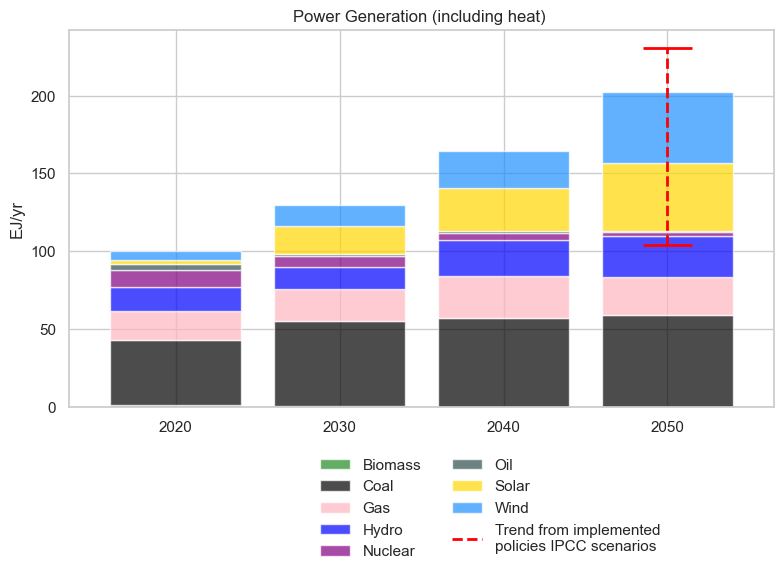

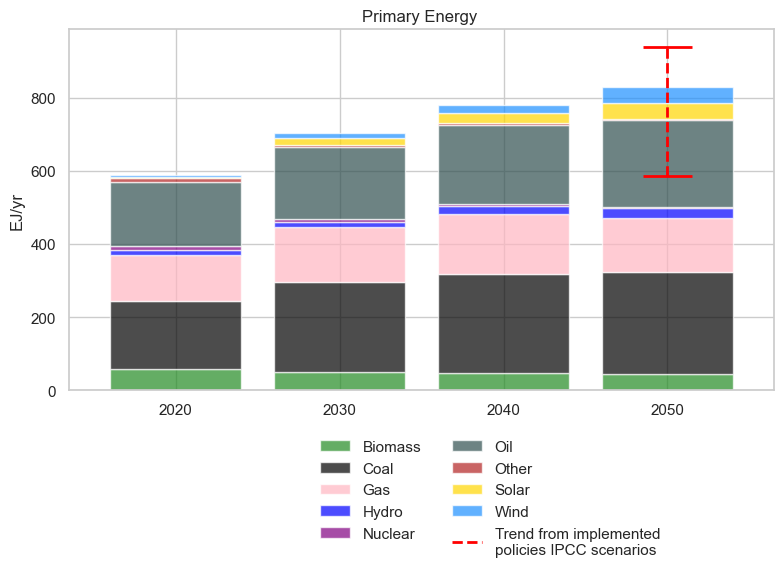

In [7]:
var_dict =  {
    'Power Generation (including heat) Shares':[[
        'Secondary Energy|Electricity|Biomass',
        'Secondary Energy|Electricity|Coal',
        'Secondary Energy|Electricity|Gas',
        'Secondary Energy|Electricity|Hydro',
        'Secondary Energy|Electricity|Nuclear',
        'Secondary Energy|Electricity|Oil',
        # 'Secondary Energy|Electricity|Other',
        'Secondary Energy|Electricity|Solar',
        'Secondary Energy|Electricity|Wind',
    ],'Secondary Energy|Electricity', 'Total Final Power Generation (including heat)'],
    'Primary Energy Shares':[[
        'Primary Energy|Biomass',
        'Primary Energy|Coal',
        'Primary Energy|Gas',
        'Primary Energy|Hydro',
        'Primary Energy|Nuclear',
        'Primary Energy|Oil',
        'Primary Energy|Other',
        'Primary Energy|Solar',
        'Primary Energy|Wind',
    ],'Primary Energy', 'Total Primary Energy'],
    }
rename_variables = {
    'Secondary Energy|Electricity|Biomass':'Biomass',
    'Secondary Energy|Electricity|Coal':'Coal',
    'Secondary Energy|Electricity|Gas':'Gas',
    'Secondary Energy|Electricity|Hydro':'Hydro',
    'Secondary Energy|Electricity|Nuclear':'Nuclear',
    'Secondary Energy|Electricity|Oil':'Oil',
    'Secondary Energy|Electricity|Solar':'Solar',
    'Secondary Energy|Electricity|Wind':'Wind',
    'Primary Energy|Biomass':'Biomass',
    'Primary Energy|Coal':'Coal',
    'Primary Energy|Gas':'Gas',
    'Primary Energy|Hydro':'Hydro',
    'Primary Energy|Nuclear':'Nuclear',
    'Primary Energy|Oil':'Oil',
    'Primary Energy|Other':'Other',
    'Primary Energy|Solar':'Solar',
    'Primary Energy|Wind':'Wind',
}
for share in var_dict.keys():
    variable = var_dict[share][1]
    df_ar6_energy_c78_data = df_ar6_energy_c78.filter(year=[2050], variable=variable).data
    min_values_c78 = df_ar6_energy_c78_data['value'].min()
    max_values_c78 = df_ar6_energy_c78_data['value'].max()

    var_list = var_dict[share][0]

    data = df_geo.filter(variable=var_list,
            year=[2010, 2020, 2030, 2040, 2050])
    
    fig, ax = plt.subplots(figsize=(8, 6))  
    # Plot the stacked bar chart
    data.plot.bar(stacked=True, ax=ax, alpha=0.7, width=0.8)
    
    # ASSIGN COLORS
    # Now loop through the segments of each bar (patches)
    patches = ax.patches
    num_variables = len(var_list)
    num_patches = len(patches)
    patch_counter = 0  # To track patches for each variable
    for i, var in enumerate(var_list):
        color = color_dict.get(var, 'firebrick')  
        num_patches_per_var = num_patches // num_variables  
        # Loop over the patches and assign colors to the correct ones
        for j in range(num_patches_per_var):
            patches[patch_counter].set_facecolor(color)
            patch_counter += 1  # Move to the next patch
    
    title = share.replace("Shares", "")
    ax.set_title(title)
    
    # Add uncertainty ranges to total
    year = 2050
    legend_label = "Trend from implemented \npolicies IPCC scenarios"
    color = 'red'
    cap_width = 0.15
    
    ax.vlines(x=3, ymin=min_values_c78, ymax=max_values_c78, color=color, linestyle='--', lw=2)  # Adjust x-position to match year index
    ax.hlines(y=min_values_c78, xmin=3 - cap_width, xmax=3 + cap_width, color=color, lw=2)
    ax.hlines(y=max_values_c78, xmin=3 - cap_width, xmax=3 + cap_width, color=color, lw=2)

    ax.set(xlabel=None)
    ax.legend().set_visible(True)
    # Get the current legend handles and labels
    handles, labels = ax.get_legend_handles_labels()

    # Replace labels with the dictionary values if found
    new_labels = [rename_variables.get(label, label) for label in labels]

    # Check if the red line already exists in the legend
    if legend_label in new_labels:
        idx = new_labels.index(legend_label)
        trend_handle = handles.pop(idx)  # Remove and save the red line handle
        legend_label = new_labels.pop(idx)  # Remove and save the label
        handles.append(trend_handle)  # Add it to the end
        new_labels.append(legend_label)  # Add it to the end

    # Now add a single red line to the legend (without modifying the last handle)
    red_line = Line2D([0], [0], color='red', lw=2, linestyle='--')
    handles.append(red_line)  # Add the red line to the handles list
    new_labels.append(legend_label)  # Add the corresponding label for the red line

    
    ax.legend(handles, new_labels, loc='upper center', bbox_to_anchor=(0.6, -0.1), ncols=2, frameon=False)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)  # Ensure proper x-axis labeling
    plt.tight_layout()

    variable_name = share.replace("(", "_").replace(")","").replace(" ", "_")
    variable_name = "10.2_" + variable_name
    plt.savefig(f"../../../plots/TOD/final_figures/chpt_10/{variable_name}.png", bbox_inches="tight")
    plt.savefig(f"../../../plots/TOD/final_figures/chpt_10/{variable_name}.svg", bbox_inches="tight")

    # Apply the rename mapping to variables
    data = data.rename(variable=rename_variables)
    data = data.timeseries()
    print(data)
    data = data.reset_index()
    data = data.drop(columns=['model','scenario','region'])
    IPCC_data = pd.DataFrame({
        2050: [min_values_c78, max_values_c78],
        'unit': 'EJ/yr',
        'variable': ['IPCC_min', 'IPCC_max']
    })
    data = pd.concat([data, IPCC_data])
    print(data)
    output_file = f"../../../plots/TOD/final_figures/chpt_10/data_for_figures/{variable_name}_data.xlsx"
    data.to_excel(output_file, index=False)

## 10.3
- Final energy by end user
- Final energy by energy mix

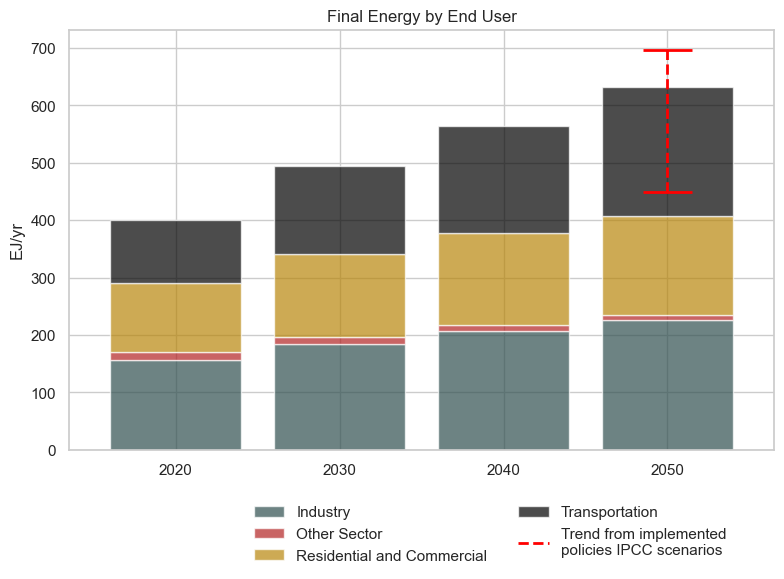

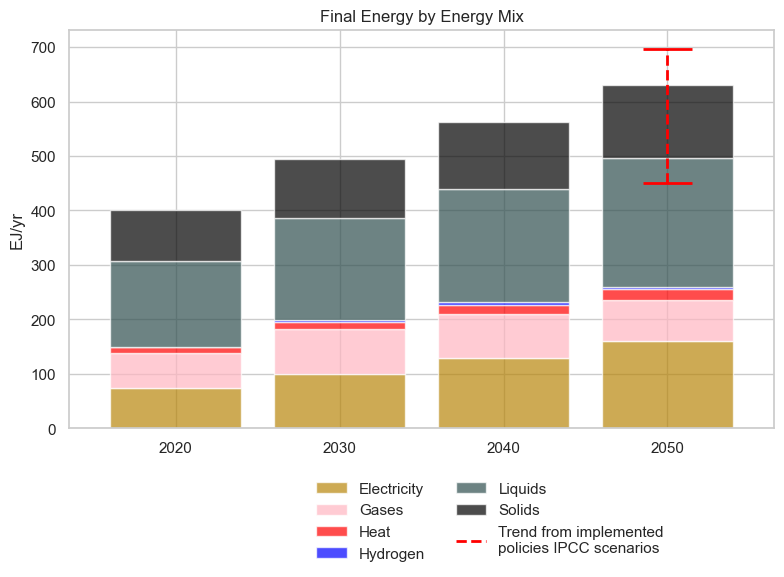

In [8]:
var_dict =  {
    'Final Energy Shares by End User':[[
        'Final Energy|Transportation',
        'Final Energy|Other Sector',
        'Final Energy|Residential and Commercial',
        'Final Energy|Industry',
        ],'Final Energy', 'Total Final Energy'],
    'Final Energy Shares by Energy Mix': [[
        'Final Energy|Electricity',
        'Final Energy|Gases',
        'Final Energy|Heat',
        'Final Energy|Hydrogen',
        'Final Energy|Liquids',
        'Final Energy|Solids',
        ],'Final Energy', 'Total Final Energy'],
    
    }
rename_variables = {
    'Final Energy|Other Sector':'Other Sector',
    'Final Energy|Transportation':'Transportation',
    'Final Energy|Residential and Commercial':'Residential and Commercial',
    'Final Energy|Industry':'Industry',
    'Final Energy|Hydrogen':'Hydrogen',
    'Final Energy|Electricity':'Electricity',
    'Final Energy|Heat':'Heat',
    'Final Energy|Gases':'Gases',
    'Final Energy|Liquids':'Liquids',
    'Final Energy|Solids':'Solids'
}

for share in var_dict.keys():

    variable = var_dict[share][1]
    df_ar6_energy_c78_data = df_ar6_energy_c78.filter(year=[2050], variable=variable).data
    min_values_c78 = df_ar6_energy_c78_data['value'].min()
    max_values_c78 = df_ar6_energy_c78_data['value'].max()

    var_list = var_dict[share][0]

    data = df_geo.filter(variable=var_list,
            year=[2010, 2020, 2030, 2040, 2050])
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot stacked bars instead of stacked lines
    data.plot.bar(stacked=True, ax=ax, alpha=0.7, width=0.8)

    #ASSIGN COLORS
    #Now loop through the segments of each bar (patches)
    patches = ax.patches
    num_variables = len(var_list)
    num_patches = len(patches)
    patch_counter = 0  # To track patches for each variable
    for i, var in enumerate(var_list):
        color = color_dict.get(var, 'firebrick')  
        num_patches_per_var = num_patches // num_variables  
        # Loop over the patches and assign colors to the correct ones
        for j in range(num_patches_per_var):
            patches[patch_counter].set_facecolor(color)
            patch_counter += 1  # Move to the next patch
            
    title = share.replace("Shares ", "")
    ax.set_title(title)
    
    # Add uncertainty ranges to total
    year = 2050
    legend_label = "Trend from implemented \npolicies IPCC scenarios"
    color = 'red'
    cap_width = 0.15
    
    ax.vlines(x=3, ymin=min_values_c78, ymax=max_values_c78, color=color, linestyle='--', lw=2)  # Adjust x-position to match year index
    ax.hlines(y=min_values_c78, xmin=3 - cap_width, xmax=3 + cap_width, color=color, lw=2)
    ax.hlines(y=max_values_c78, xmin=3 - cap_width, xmax=3 + cap_width, color=color, lw=2)

    ax.set(xlabel=None)
    ax.legend().set_visible(True)
    # Get the current legend handles and labels
    handles, labels = ax.get_legend_handles_labels()

    # Replace labels with the dictionary values if found
    new_labels = [rename_variables.get(label, label) for label in labels]

    # Check if the red line already exists in the legend
    if legend_label in new_labels:
        idx = new_labels.index(legend_label)
        trend_handle = handles.pop(idx)  # Remove and save the red line handle
        legend_label = new_labels.pop(idx)  # Remove and save the label
        handles.append(trend_handle)  # Add it to the end
        new_labels.append(legend_label)  # Add it to the end

    # Now add a single red line to the legend (without modifying the last handle)
    red_line = Line2D([0], [0], color='red', lw=2, linestyle='--')
    handles.append(red_line)  # Add the red line to the handles list
    new_labels.append(legend_label)  # Add the corresponding label for the red line

    
    ax.legend(handles, new_labels, loc='upper center', bbox_to_anchor=(0.6, -0.1), ncols=2, frameon=False)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)  # Ensure proper x-axis labeling
    plt.tight_layout()

    variable_name = share.replace("(", "_").replace(")","").replace(" ", "_")
    variable_name = "10.3_" + variable_name
    plt.savefig(f"../../../plots/TOD/final_figures/chpt_10/{variable_name}.png", bbox_inches="tight")
    plt.savefig(f"../../../plots/TOD/final_figures/chpt_10/{variable_name}.svg", bbox_inches="tight")

    # Apply the rename mapping to variables
    data = data.rename(variable=rename_variables)
    data = data.timeseries()
    data = data.reset_index()
    data = data.drop(columns=['model','scenario','region'])
    IPCC_data = pd.DataFrame({
        2050: [min_values_c78, max_values_c78],
        'unit': 'EJ/yr',
        'variable': ['IPCC_min', 'IPCC_max']
    })
    data = pd.concat([data, IPCC_data])
    output_file = f"../../../plots/TOD/final_figures/chpt_10/data_for_figures/{variable_name}_data.xlsx"
    data.to_excel(output_file, index=False)


## 10.4
- Food Demand 
- Agricultural Demand
- Yield

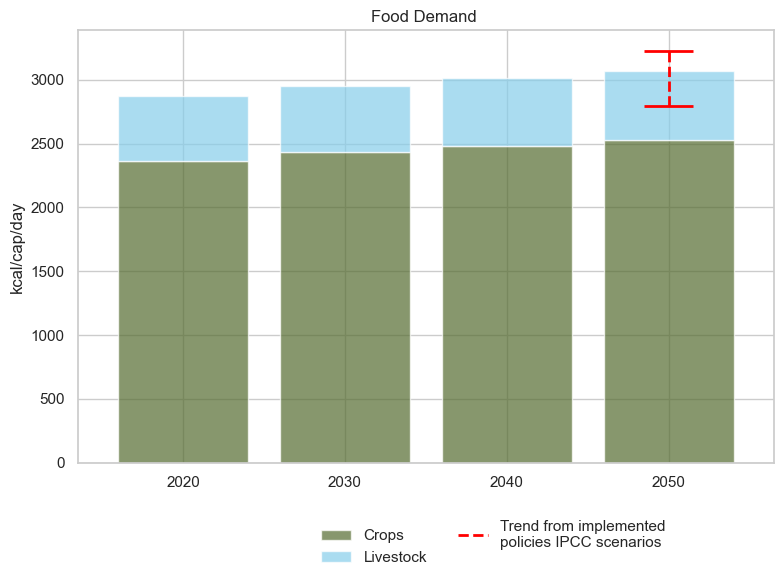

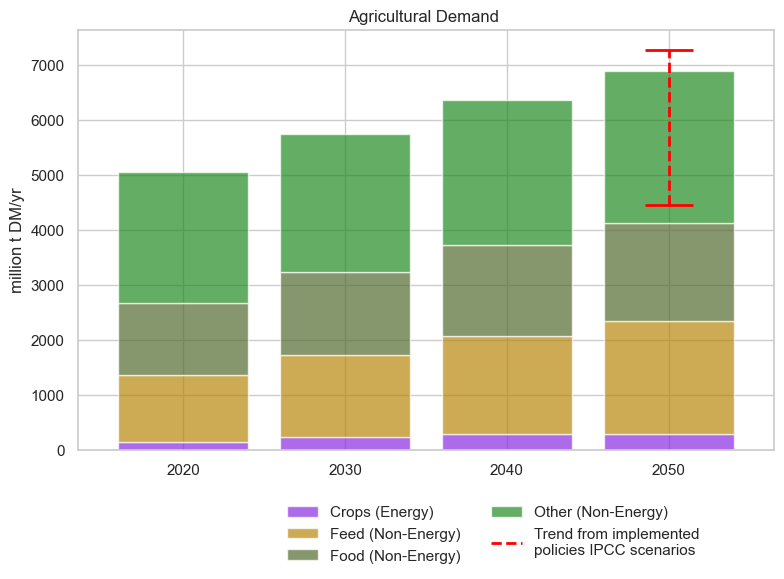

In [9]:
var_dict =  {
    'Food Demand Shares':[[
        'Food Demand|Crops',
        'Food Demand|Livestock',
    ], 'Food Demand', 'Total Food Demand'],
    'Agricultural Demand Shares':[[
        'Agricultural Demand|Energy|Crops',
        'Agricultural Demand|Non-Energy|Crops|Feed',
        'Agricultural Demand|Non-Energy|Crops|Food',
        'Agricultural Demand|Non-Energy|Crops|Other'
    ], 'Agricultural Demand|Crops', 'Total Agricultural Demand'],
    }
rename_variables = {
    'Food Demand|Crops':'Crops',
    'Food Demand|Livestock':'Livestock',
    'Agricultural Demand|Energy|Crops':'Crops (Energy)',
    'Agricultural Demand|Non-Energy|Crops|Feed':'Feed (Non-Energy)',
    'Agricultural Demand|Non-Energy|Crops|Food':'Food (Non-Energy)',
    'Agricultural Demand|Non-Energy|Crops|Other':'Other (Non-Energy)'
}
for share in var_dict.keys():

    variable = var_dict[share][1]
    df_ar6_energy_c78_data = df_ar6_energy_c78.filter(year=[2050], variable=variable).data
    min_values_c78 = df_ar6_energy_c78_data['value'].min()
    max_values_c78 = df_ar6_energy_c78_data['value'].max()

    var_list = var_dict[share][0]

    data = df_geo.filter(variable=var_list,
            year=[2010, 2020, 2030, 2040, 2050])
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot stacked bars instead of stacked lines
    data.plot.bar(stacked=True, ax=ax, alpha=0.7, width=0.8)

    #ASSIGN COLORS
    #Now loop through the segments of each bar (patches)
    patches = ax.patches
    num_variables = len(var_list)
    num_patches = len(patches)
    patch_counter = 0  # To track patches for each variable
    for i, var in enumerate(var_list):
        color = color_dict.get(var, 'firebrick')  
        num_patches_per_var = num_patches // num_variables  
        # Loop over the patches and assign colors to the correct ones
        for j in range(num_patches_per_var):
            patches[patch_counter].set_facecolor(color)
            patch_counter += 1  # Move to the next patch

    title = share.replace("Shares", "")
    ax.set_title(title)
    
    # Add uncertainty ranges to total
    year = 2050
    legend_label = "Trend from implemented \npolicies IPCC scenarios"
    color = 'red'
    cap_width = 0.15
    
    ax.vlines(x=3, ymin=min_values_c78, ymax=max_values_c78, color=color, linestyle='--', lw=2)  # Adjust x-position to match year index
    ax.hlines(y=min_values_c78, xmin=3 - cap_width, xmax=3 + cap_width, color=color, lw=2)
    ax.hlines(y=max_values_c78, xmin=3 - cap_width, xmax=3 + cap_width, color=color, lw=2)

    ax.set(xlabel=None)
    ax.legend().set_visible(True)
    # Get the current legend handles and labels
    handles, labels = ax.get_legend_handles_labels()

    # Replace labels with the dictionary values if found
    new_labels = [rename_variables.get(label, label) for label in labels]

    # Check if the red line already exists in the legend
    if legend_label in new_labels:
        idx = new_labels.index(legend_label)
        trend_handle = handles.pop(idx)  # Remove and save the red line handle
        legend_label = new_labels.pop(idx)  # Remove and save the label
        handles.append(trend_handle)  # Add it to the end
        new_labels.append(legend_label)  # Add it to the end

    # Now add a single red line to the legend (without modifying the last handle)
    red_line = Line2D([0], [0], color='red', lw=2, linestyle='--')
    handles.append(red_line)  # Add the red line to the handles list
    new_labels.append(legend_label)  # Add the corresponding label for the red line

    
    ax.legend(handles, new_labels, loc='upper center', bbox_to_anchor=(0.6, -0.1), ncols=2, frameon=False)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)  # Ensure proper x-axis labeling
    plt.tight_layout()

    variable_name = share.replace("(", "_").replace(")","").replace(" ", "_")
    variable_name = "10.4_" + variable_name
    plt.savefig(f"../../../plots/TOD/final_figures/chpt_10/{variable_name}.png", bbox_inches="tight")
    plt.savefig(f"../../../plots/TOD/final_figures/chpt_10/{variable_name}.svg", bbox_inches="tight")

    # Apply the rename mapping to variables
    data = data.rename(variable=rename_variables)
    data = data.timeseries()
    data = data.reset_index()
    data = data.drop(columns=['model','scenario','region'])
    IPCC_data = pd.DataFrame({
        2050: [min_values_c78, max_values_c78],
        'variable': ['IPCC_min', 'IPCC_max']
    })
    data = pd.concat([data, IPCC_data])
    output_file = f"../../../plots/TOD/final_figures/chpt_10/data_for_figures/{variable_name}_data.xlsx"
    data.to_excel(output_file, index=False)


C:\Users\maycocks\AppData\Local\Temp\2\ipykernel_10148\481396205.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geo_data_yield["year"] = geo_data_yield["year"].astype(str)
C:\Users\maycocks\AppData\Local\Temp\2\ipykernel_10148\481396205.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ar6_data_yield["year"] = ar6_data_yield["year"].astype(str)


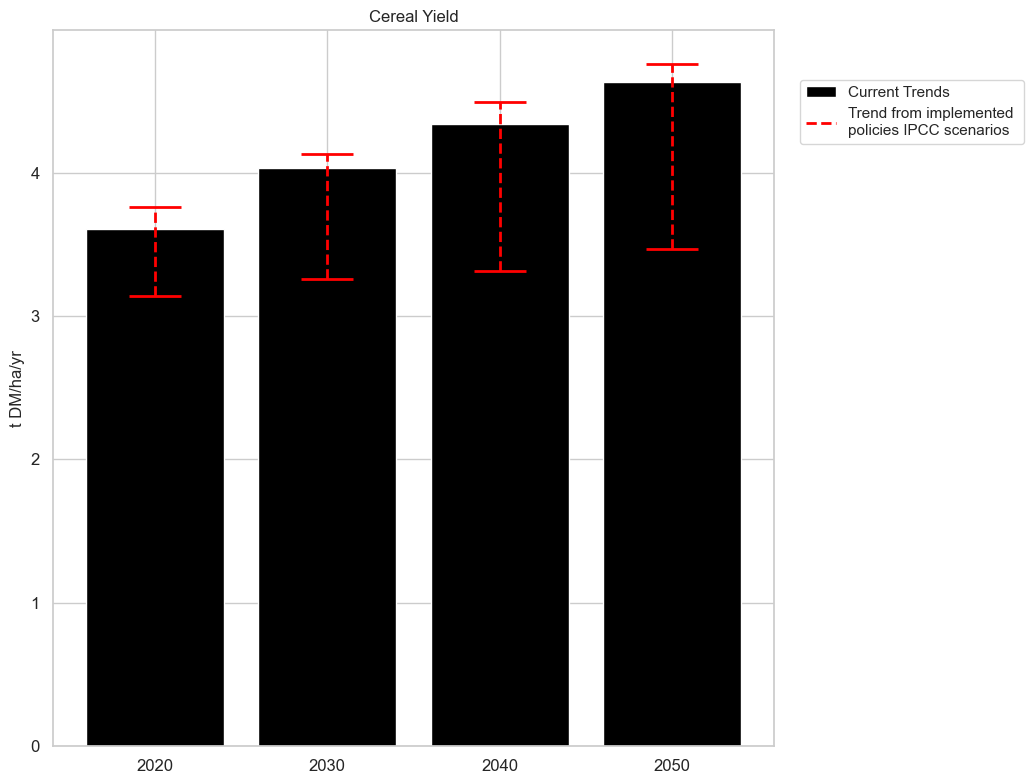

In [17]:
df_geo_data = df_lines_geo.data
df_ar6_data = df_ar6.data
# variables = df_geo_data.variable.unique()
variables = ['Yield|Cereal']
for variable in variables:
    # Filter the data
    geo_data_yield = df_geo_data[df_geo_data["variable"] == variable]
    ar6_data_yield = df_ar6_data[df_ar6_data["variable"] == variable]

    # Ensure 'year' is treated as a categorical variable
    geo_data_yield["year"] = geo_data_yield["year"].astype(str)
    ar6_data_yield["year"] = ar6_data_yield["year"].astype(str)

    # Define colors
    color_main = "black"
    color_error = "red"
    cap_width = 0.15

    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Barplot for geo_data
    sns.barplot(
        data=geo_data_yield,
        x="year",  # Categorical
        y="value",
        color=color_main,
        ax=ax,
        order=sorted(geo_data_yield["year"].unique()),  # Ensure correct order
        label="Current Trends"
    )

    # Adding error bars for AR6 data (uncertainty range)
    x_positions = {year: idx for idx, year in enumerate(sorted(geo_data_yield["year"].unique()))}

    for year in ar6_data_yield["year"].unique():
        year_data = ar6_data_yield[ar6_data_yield["year"] == year]
        value_min = year_data["value"].min()
        value_max = year_data["value"].max()
        y_position = year_data["value"].mean()

        if year in x_positions:  # Only plot for existing bars
            x_pos = x_positions[year]

            ax.vlines(x=x_pos, ymin=value_min, ymax=value_max, color=color_error, linestyle='--', lw=2)
            ax.hlines(y=value_min, xmin=x_pos - cap_width, xmax=x_pos + cap_width, color=color_error, lw=2)
            ax.hlines(y=value_max, xmin=x_pos - cap_width, xmax=x_pos + cap_width, color=color_error, lw=2)

    # Formatting
    ax.legend().set_visible(False)
    plt.ylabel(geo_data_yield["unit"].iloc[0], fontsize=12)
    ax.set_ylim(0, ax.get_ylim()[1])  # Ensure bars start from 0
    plt.title('Cereal Yield')
    plt.xlabel('')
    plt.xticks(rotation=0, fontsize=12)
    plt.yticks(fontsize=12)

    # Add Legend manually
    handles, labels = ax.get_legend_handles_labels()
    red_line = Line2D([0], [0], color='red', lw=2, linestyle='--')
    handles.append(red_line)
    labels.append('Trend from implemented \npolicies IPCC scenarios')
    fig.legend(handles, labels, bbox_to_anchor=(1.3, 0.9))

    plt.grid(True)
    plt.tight_layout()
    

    variable_name = "10.4_Cereal_Yield"
    plt.savefig(f"../../../plots/TOD/final_figures/chpt_10/{variable_name}.png", bbox_inches="tight")
    plt.savefig(f"../../../plots/TOD/final_figures/chpt_10/{variable_name}.svg", bbox_inches="tight")
    plt.show()
    years = sorted(geo_data_yield["year"].unique())
    variable_data = {"variable": "Yield", "unit": geo_data_yield["unit"].iloc[0]}
    ipcc_min_data = {"variable": "IPCC_min", "unit": geo_data_yield["unit"].iloc[0]}
    ipcc_max_data = {"variable": "IPCC_max", "unit": geo_data_yield["unit"].iloc[0]}
    output_data = []
    for year in years:
        # Get values from geo data
        geo_value = geo_data_yield.loc[geo_data_yield["year"] == year, "value"].values
        variable_data[year] = geo_value[0] if len(geo_value) > 0 else None

        # Get min/max values from IPCC data
        ipcc_values = ar6_data_yield.loc[ar6_data_yield["year"] == year, "value"]
        ipcc_min_data[year] = ipcc_values.min() if not ipcc_values.empty else None
        ipcc_max_data[year] = ipcc_values.max() if not ipcc_values.empty else None
    output_data.append(variable_data)
    output_data.append(ipcc_min_data)
    output_data.append(ipcc_max_data)
    df_output = pd.DataFrame(output_data)
    output_file = f"../../../plots/TOD/final_figures/chpt_10/data_for_figures/{variable_name}_data.xlsx"
    df_output.to_excel(output_file, index=False)

## 10.6
- GHG emission
- Temperature

        model scenario region              variable             unit  year  \
0   Emissions      REF  World         Emissions|CH4        Mt CH4/yr  2020   
1   Emissions      REF  World         Emissions|CH4        Mt CH4/yr  2030   
2   Emissions      REF  World         Emissions|CH4        Mt CH4/yr  2040   
3   Emissions      REF  World         Emissions|CH4        Mt CH4/yr  2050   
4   Emissions      REF  World   Emissions|CO2|AFOLU        Mt CO2/yr  2020   
5   Emissions      REF  World   Emissions|CO2|AFOLU        Mt CO2/yr  2030   
6   Emissions      REF  World   Emissions|CO2|AFOLU        Mt CO2/yr  2040   
7   Emissions      REF  World   Emissions|CO2|AFOLU        Mt CO2/yr  2050   
8   Emissions      REF  World  Emissions|CO2|Energy        Mt CO2/yr  2020   
9   Emissions      REF  World  Emissions|CO2|Energy        Mt CO2/yr  2030   
10  Emissions      REF  World  Emissions|CO2|Energy        Mt CO2/yr  2040   
11  Emissions      REF  World  Emissions|CO2|Energy        Mt CO

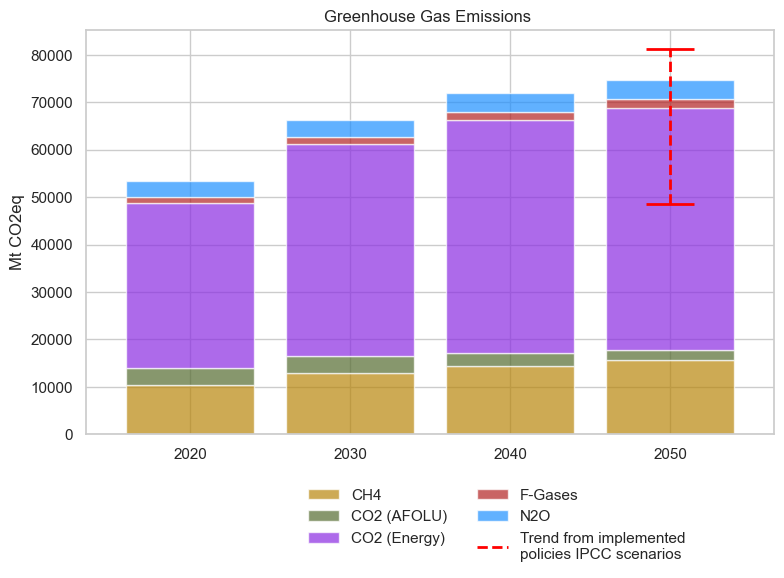

In [14]:
var_dict =  {
    'Greenhouse Gas Emissions Shares':[[
        'Emissions|CH4',
        'Emissions|CO2|AFOLU',
        'Emissions|CO2|Energy',
        'Emissions|N2O Mt',
        'Emissions|F-Gases',
    ], 'Emissions|Kyoto Gases', 'Total Greenhouse Gas Emissions'],
    }
rename_variables = {
    'Emissions|N2O Mt':'N2O',
    'Emissions|CH4':'CH4',
    'Emissions|CO2|AFOLU':'CO2 (AFOLU)',
    'Emissions|CO2|Energy':'CO2 (Energy)',
    'Emissions|F-Gases': 'F-Gases',
}

gwp_dict = {
    'Emissions|CH4':27,
    'Emissions|N2O Mt':273,
}

for share in var_dict.keys():

    variable = var_dict[share][1]
    df_ar6_energy_c78_data = df_ar6_energy_c78.filter(year=[2050], variable=variable).data
    min_values_c78 = df_ar6_energy_c78_data['value'].min()
    max_values_c78 = df_ar6_energy_c78_data['value'].max()

    var_list = var_dict[share][0]

    data = df_geo.filter(variable=var_list,
            year=[2010, 2020, 2030, 2040, 2050])
    print(data.data)
    data_pandas = data.data
    data_pandas.loc[data_pandas['variable'] == 'Emissions|CH4', 'value'] *= gwp_dict['Emissions|CH4']
    data_pandas.loc[data_pandas['variable'] == 'Emissions|N2O Mt', 'value'] *= gwp_dict['Emissions|N2O Mt']
    data = pyam.IamDataFrame(data_pandas)
    print(data.data)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot stacked bars instead of stacked lines
    data.plot.bar(stacked=True, ax=ax, alpha=0.7, width=0.8)

    # ASSIGN COLORS
    # Now loop through the segments of each bar (patches)
    patches = ax.patches
    num_variables = len(var_list)
    num_patches = len(patches)
    legend_handles = []
    legend_labels = []
    patch_counter = 0  # To track patches for each variable
    for i, var in enumerate(var_list):
        color = color_dict.get(var, 'firebrick')  
        num_patches_per_var = num_patches // num_variables  
        # Loop over the patches and assign colors to the correct ones
        for j in range(num_patches_per_var):
            patches[patch_counter].set_facecolor(color)
            patch_counter += 1  # Move to the next patch

    title = share.replace("Shares", "")
    ax.set_title(title)
    
    # Add uncertainty ranges to total
    year = 2050
    legend_label = "Trend from implemented \npolicies IPCC scenarios"
    color = 'red'
    cap_width = 0.15
    
    ax.vlines(x=3, ymin=min_values_c78, ymax=max_values_c78, color=color, linestyle='--', lw=2)  # Adjust x-position to match year index
    ax.hlines(y=min_values_c78, xmin=3 - cap_width, xmax=3 + cap_width, color=color, lw=2)
    ax.hlines(y=max_values_c78, xmin=3 - cap_width, xmax=3 + cap_width, color=color, lw=2)

    ax.set(xlabel=None)
    ax.legend().set_visible(True)
    # Get the current legend handles and labels
    handles, labels = ax.get_legend_handles_labels()
    print(handles, labels)

    # Replace labels with the dictionary values if found
    new_labels = [rename_variables.get(label, label) for label in labels]

    # Check if the red line already exists in the legend
    if legend_label in new_labels:
        idx = new_labels.index(legend_label)
        trend_handle = handles.pop(idx)  # Remove and save the red line handle
        legend_label = new_labels.pop(idx)  # Remove and save the label
        handles.append(trend_handle)  # Add it to the end
        new_labels.append(legend_label)  # Add it to the end

    # Now add a single red line to the legend (without modifying the last handle)
    red_line = Line2D([0], [0], color='red', lw=2, linestyle='--')
    handles.append(red_line)  # Add the red line to the handles list
    new_labels.append(legend_label)  # Add the corresponding label for the red line

    
    ax.legend(handles, new_labels, loc='upper center', bbox_to_anchor=(0.6, -0.1), ncols=2, frameon=False)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)  # Ensure proper x-axis labeling
    ax.set_ylabel("Mt CO2eq", fontsize=12)
    plt.tight_layout()

    variable_name = share.replace("(", "_").replace(")","").replace(" ", "_")
    variable_name = "10.6_" + variable_name
    plt.savefig(f"../../../plots/TOD/final_figures/chpt_10/{variable_name}.png", bbox_inches="tight")
    plt.savefig(f"../../../plots/TOD/final_figures/chpt_10/{variable_name}.svg", bbox_inches="tight")

    # Apply the rename mapping to variables
    data = data.rename(variable=rename_variables)
    data = data.timeseries()
    data = data.reset_index()
    data = data.drop(columns=['model','scenario','region'])
    IPCC_data = pd.DataFrame({
        2050: [min_values_c78, max_values_c78],
        'variable': ['IPCC_min', 'IPCC_max']
    })
    data = pd.concat([data, IPCC_data])
    output_file = f"../../../plots/TOD/final_figures/chpt_10/data_for_figures/{variable_name}_data.xlsx"
    data.to_excel(output_file, index=False)

C:\Users\maycocks\AppData\Local\Temp\2\ipykernel_10148\2031457302.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geo_data_temp["year"] = geo_data_temp["year"].astype(str)
C:\Users\maycocks\AppData\Local\Temp\2\ipykernel_10148\2031457302.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ar6_data_temp["year"] = ar6_data_temp["year"].astype(str)


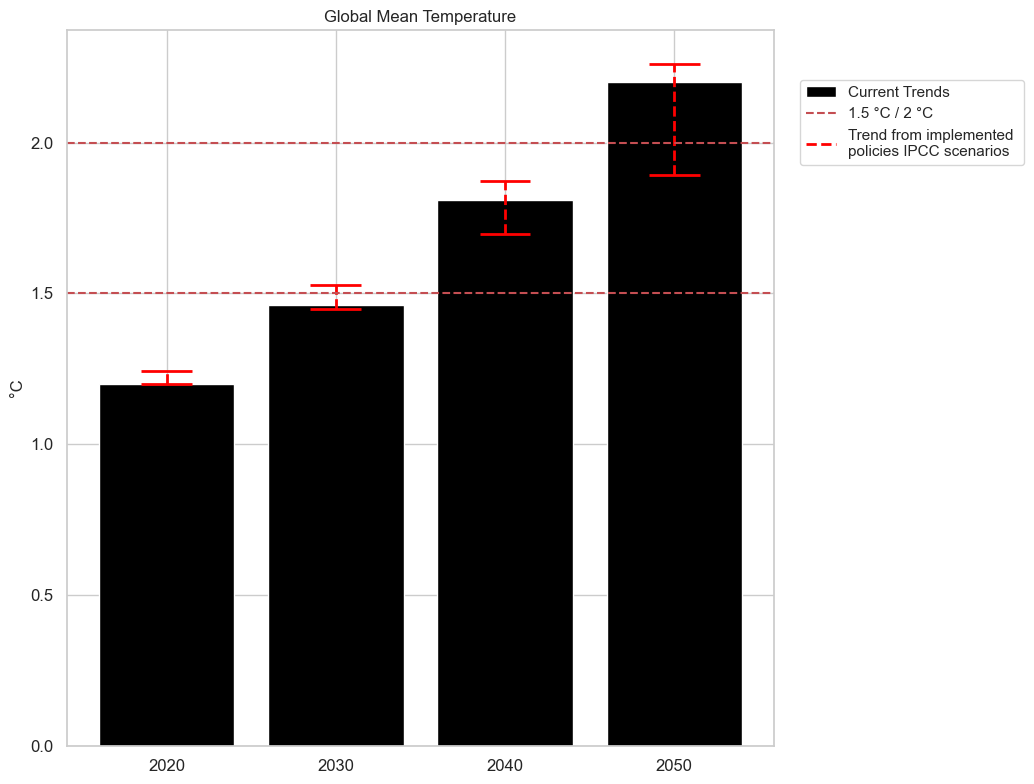

In [18]:
variables = ['Temperature|Global Mean']
for variable in variables:
    # Filter the data
    geo_data_temp = df_geo_data[df_geo_data["variable"] == variable]
    ar6_data_temp = df_ar6_data[df_ar6_data["variable"] == variable]
    # Ensure 'year' is treated as a categorical variable
    geo_data_temp["year"] = geo_data_temp["year"].astype(str)
    ar6_data_temp["year"] = ar6_data_temp["year"].astype(str)

    # Define colors
    color_main = "black"
    color_error = "red"
    cap_width = 0.15

    fig, ax = plt.subplots(figsize=(8, 8))

    # Barplot for geo_data
    sns.barplot(
        data=geo_data_temp,
        x="year",  # Categorical
        y="value",
        color=color_main,
        ax=ax,
        order=sorted(geo_data_temp["year"].unique()),  # Ensure correct order
        label="Current Trends"
    )

    # Adding error bars for AR6 data (uncertainty range)
    x_positions = {year: idx for idx, year in enumerate(sorted(geo_data_temp["year"].unique()))}

    for year in ar6_data_temp["year"].unique():
        year_data = ar6_data_temp[ar6_data_temp["year"] == year]
        value_min = year_data["value"].min()
        value_max = year_data["value"].max()
        y_position = year_data["value"].mean()

        if year in x_positions:  # Only plot for existing bars
            x_pos = x_positions[year]

            ax.vlines(x=x_pos, ymin=value_min, ymax=value_max, color=color_error, linestyle='--', lw=2)
            ax.hlines(y=value_min, xmin=x_pos - cap_width, xmax=x_pos + cap_width, color=color_error, lw=2)
            ax.hlines(y=value_max, xmin=x_pos - cap_width, xmax=x_pos + cap_width, color=color_error, lw=2)

    # Formatting
    ax.axhline(y = 1.5, color = 'r', linestyle = '--')
    ax.axhline(y = 2, color = 'r', linestyle = '--') 
    ax.legend().set_visible(False)
    plt.ylabel(geo_data_temp["unit"].iloc[0], fontsize=12)
    ax.set_ylim(0, ax.get_ylim()[1])  # Ensure bars start from 0
    plt.title('Global Mean Temperature')
    plt.xlabel('')
    plt.xticks(rotation=0, fontsize=12)
    plt.yticks(fontsize=12)

    # Add Legend manually
    handles, labels = ax.get_legend_handles_labels()
    red_line = Line2D([0], [0], color='red', lw=2, linestyle='--')
    temp_line = Line2D([0], [0], color='r', linestyle='--')
    handles.append(temp_line)
    labels.append('1.5 °C / 2 °C')
    handles.append(red_line)
    labels.append('Trend from implemented \npolicies IPCC scenarios')
    fig.legend(handles, labels, bbox_to_anchor=(1.3, 0.9))
    
    plt.grid(True)
    plt.tight_layout()


    variable_name = "10.6_Global_Mean_Temperature"
    plt.savefig(f"../../../plots/TOD/final_figures/chpt_10/{variable_name}.png", bbox_inches="tight")
    plt.savefig(f"../../../plots/TOD/final_figures/chpt_10/{variable_name}.svg", bbox_inches="tight")

    years = sorted(geo_data_temp["year"].unique())
    variable_data = {"variable": "Temperature", "unit": geo_data_temp["unit"].iloc[0]}
    ipcc_min_data = {"variable": "IPCC_min", "unit": geo_data_temp["unit"].iloc[0]}
    ipcc_max_data = {"variable": "IPCC_max", "unit": geo_data_temp["unit"].iloc[0]}
    output_data = []
    for year in years:
        # Get values from geo data
        geo_value = geo_data_temp.loc[geo_data_temp["year"] == year, "value"].values
        variable_data[year] = geo_value[0] if len(geo_value) > 0 else None

        # Get min/max values from IPCC data
        ipcc_values = ar6_data_temp.loc[ar6_data_temp["year"] == year, "value"]
        ipcc_min_data[year] = ipcc_values.min() if not ipcc_values.empty else None
        ipcc_max_data[year] = ipcc_values.max() if not ipcc_values.empty else None
    output_data.append(variable_data)
    output_data.append(ipcc_min_data)
    output_data.append(ipcc_max_data)
    df_output = pd.DataFrame(output_data)
    output_file = f"../../../plots/TOD/final_figures/chpt_10/data_for_figures/{variable_name}_data.xlsx"
    df_output.to_excel(output_file, index=False)

# Loss of natural land cover

In [35]:
df_ar6_land = df_ar6.filter(
    variable=[
        'Land Cover*'
        ],
)
data = df_ar6_land.timeseries()
data = data.reset_index()
output_file = f"../../../plots/TOD/final_figures/chpt_10/data_for_figures/IPCC_landcover_data.xlsx"
data.to_excel(output_file, index=False)

                     model         scenario region            variable  \
0              AIM/CGE 2.1        CO_CurPol  World  Natural Land Cover   
1              AIM/CGE 2.1        CO_CurPol  World  Natural Land Cover   
2              AIM/CGE 2.1        CO_CurPol  World  Natural Land Cover   
3              AIM/CGE 2.1        CO_CurPol  World  Natural Land Cover   
4              AIM/CGE 2.1        CO_CurPol  World  Natural Land Cover   
..                     ...              ...    ...                 ...   
153  REMIND-MAgPIE 2.1-4.2  SusDev_SSP2-NPi  World  Natural Land Cover   
154  REMIND-MAgPIE 2.1-4.2  SusDev_SSP2-NPi  World  Natural Land Cover   
155  REMIND-MAgPIE 2.1-4.2  SusDev_SSP2-NPi  World  Natural Land Cover   
156  REMIND-MAgPIE 2.1-4.2  SusDev_SSP2-NPi  World  Natural Land Cover   
157  REMIND-MAgPIE 2.1-4.2  SusDev_SSP2-NPi  World  Natural Land Cover   

           unit  year      value  
0    million ha  2020  5870.3662  
1    million ha  2025  5836.2142  
2    m

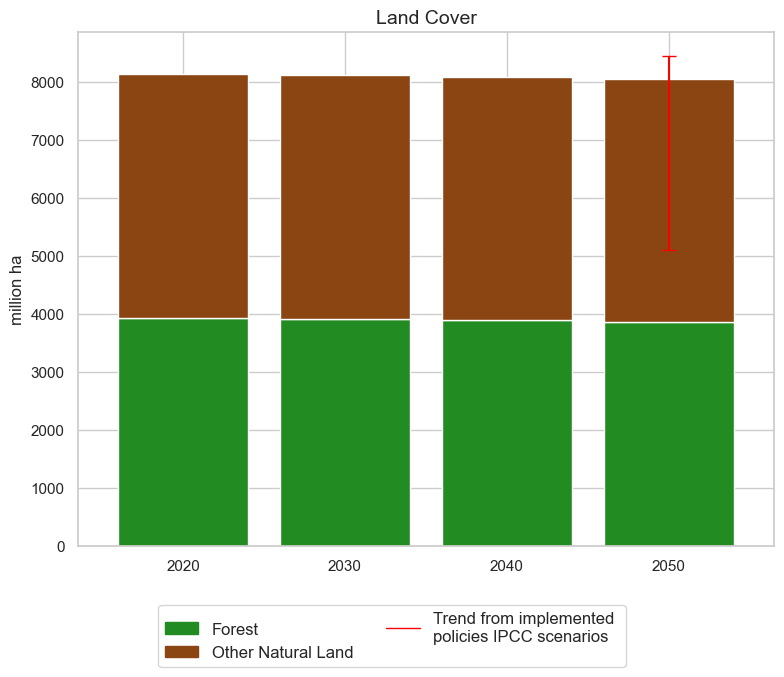

In [34]:
df_ar6_land = df_ar6.filter(
    variable=[
        'Land Cover|Forest',
        'Land Cover|Other Land'
        ],
)

# Add variables to get natural land cover
df_ar6_land = df_ar6_land.add('Land Cover|Forest',
                              'Land Cover|Other Land',
                              'Natural Land Cover',
                              ignore_units=False)
print(df_ar6_land.data)
# Show the data for 2050
print(df_ar6_land.filter(year=2050).data)

land_cover = pd.read_excel('../../../data/TOD/model_results/to_share/IMAGE_and_AIM_to_share_1.xlsx')
land_cover.rename(columns={'topic':'model'}, inplace=True)
land_cover = pyam.IamDataFrame(land_cover)
land_cover.filter(variable=[
    'dLand Cover|Forest',
    'eLand Cover|Other Natural Land',
    ], year=[2020,2030,2040,2050],scenario='REF',region='World',inplace=True)

colors = {
    'dLand Cover|Forest': 'forestgreen',
    'eLand Cover|Other Natural Land': 'saddlebrown',
    }

fig, axes = plt.subplots(figsize=(8, 6))
var_list = [
    'dLand Cover|Forest',
    'eLand Cover|Other Natural Land',
]
# Plot the stacked bar chart for land cover data (original values)
land_cover.plot.bar(stacked=True, ax=axes, width=0.8)

# Assign colors to each segment of the stacked bars
patches = axes.patches
num_variables = len(var_list)
num_patches = len(patches)
patch_counter = 0  # To track patches for each variable

for i, var in enumerate(var_list):
    color = colors.get(var, 'firebrick')
    num_patches_per_var = num_patches // num_variables
    for j in range(num_patches_per_var):
        patches[patch_counter].set_facecolor(color)
        patch_counter += 1  # Move to the next patch

# Set title and other properties for the first subplot
axes.set_title("Land Cover", fontsize=14)
axes.set_xlabel(None)  # Remove x-axis label
axes.set_xticklabels(axes.get_xticklabels(), rotation=0)

# Remove legends from both subplots
axes.legend().set_visible(False)

legend_labels = [var.split('|')[1] for var in colors.keys()]  # Drop "Land Cover|"
# Rename labels
new_labels = {
    'Forest': 'Forest',
    'Other Natural Land': 'Other Natural Land'
}
legend_labels = [new_labels.get(label, label) for label in legend_labels]
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(colors.values(), legend_labels)]
red_line = Line2D([0], [0], color='red', lw=1, linestyle='-',label='Trend from implemented \npolicies IPCC scenarios')
legend_patches.append(red_line)  


# Add the legend to the figure at the bottom with 2 columns
fig.legend(handles=legend_patches, loc='upper center', bbox_to_anchor=(0.5, -0.009), ncol=2, fontsize=12)

error_data = df_ar6_land.filter(variable='Natural Land Cover', year=2050)

if not error_data.empty:
    min_val = error_data.data['value'].min()
    max_val = error_data.data['value'].max()
    print(f"Min value: {min_val}, Max value: {max_val}")
    mean_val = error_data.data['value'].mean() # Using mean as the central point for the error bar

    # Find the position of the 2050 bar
    # The x-tick labels are typically in the order of your years from the filtered land_cover data
    x_pos_2050 = 3 # Fallback, will likely place it off-chart

    # Calculate the height of the 2050 bar for 'Natural Land Cover' in land_cover
    bar_height_2050_forest = land_cover.filter(
        year=2050, variable='dLand Cover|Forest', scenario='REF', region='World'
    ).data['value'].iloc[0] if not land_cover.filter(year=2050, variable='dLand Cover|Forest', scenario='REF', region='World').empty else 0

    bar_height_2050_other = land_cover.filter(
        year=2050, variable='eLand Cover|Other Natural Land', scenario='REF', region='World'
    ).data['value'].iloc[0] if not land_cover.filter(year=2050, variable='eLand Cover|Other Natural Land', scenario='REF', region='World').empty else 0

    total_bar_height_2050 = bar_height_2050_forest + bar_height_2050_other

    # The y-coordinate for the error bar will be the top of your stacked bar for 2050.
    # The 'yerr' should represent the distance from the mean to the min, and from the mean to the max.
    yerr_lower = mean_val - min_val
    yerr_upper = max_val - mean_val

    # Plot the error bar
    # Use the total height of the bar as the base for the error bar, and center it
    # slightly above the bar or at the mean_val itself
    axes.errorbar(
        x=x_pos_2050,
        y=mean_val, # Use the mean value as the central point for the error bar
        yerr=[[yerr_lower], [yerr_upper]], # Requires a list of lists for asymmetric errors
        color='red', # Color of the error bar
        capsize=5, # Length of the caps on the error bars
        elinewidth=1.5, # Thickness of the error bar lines
        zorder=10, # Ensure error bars are on top
        linestyle='--', 
    )

else:
    print("No data found for 'Natural Land Cover' in 2050 from df_ar6_land to plot error bars.")



# Adjust layout to prevent overlap
plt.tight_layout()

variable_name = "landcover"
variable_name = "natural_land_" + variable_name
plt.savefig(f"../../../plots/TOD/final_figures/chpt_10/{variable_name}.png", bbox_inches="tight")
plt.savefig(f"../../../plots/TOD/final_figures/chpt_10/{variable_name}.svg", bbox_inches="tight")

# Apply the rename mapping to variables
data = land_cover.timeseries()
data = data.reset_index()
data = data.drop(columns=['model','scenario','region'])
output_file = f"../../../plots/TOD/final_figures/chpt_10/data_for_figures/{variable_name}_data.xlsx"
data.to_excel(output_file, index=False)


In [ ]:
df_ar6_land = df_ar6.filter(
    variable=[
        'Land Cover|Forest',
        'Land Cover|Other Land'
        ],
)

# Add variables to get natural land cover
df_ar6_land = df_ar6_land.add('Land Cover|Forest',
                              'Land Cover|Other Land',
                              'Natural Land Cover',
                              ignore_units=False)

land_cover = pd.read_excel('../../../data/TOD/model_results/to_share/IMAGE_and_AIM_to_share_1.xlsx')
land_cover.rename(columns={'topic':'model'}, inplace=True)
land_cover = pyam.IamDataFrame(land_cover)
land_cover.filter(variable=[
    'bLand Cover|Cropland',
    'dLand Cover|Forest',
    'eLand Cover|Other Natural Land',
    'aLand Cover|Other',
    'cLand Cover|Pasture'
    ], year=[2020,2030,2040,2050],scenario='REF',region='World',inplace=True)

colors = {
    'aLand Cover|Other': 'steelblue',
    'bLand Cover|Cropland': 'darkslategray',
    'cLand Cover|Pasture': 'darkgoldenrod',
    'dLand Cover|Forest': 'forestgreen',
    'eLand Cover|Other Natural Land': 'saddlebrown',
    }

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

land_cover_2020 = land_cover.filter(year=2020)
var_list = [
    'aLand Cover|Other',
    'bLand Cover|Cropland',
    'cLand Cover|Pasture',
    'dLand Cover|Forest',
    'eLand Cover|Other Natural Land',
]
# Plot the stacked bar chart for land cover data (original values)
land_cover_2020.plot.bar(stacked=True, ax=axes[0], width=0.8)

# Assign colors to each segment of the stacked bars

patches = axes[0].patches
num_variables = len(var_list)
num_patches = len(patches)
patch_counter = 0  # To track patches for each variable

for i, var in enumerate(var_list):
    color = colors.get(var, 'firebrick')
    num_patches_per_var = num_patches // num_variables
    for j in range(num_patches_per_var):
        patches[patch_counter].set_facecolor(color)
        patch_counter += 1  # Move to the next patch

# Set title and other properties for the first subplot
axes[0].set_title("Land Cover", fontsize=14)
axes[0].set_xlabel(None)  # Remove x-axis label
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Prepare data for absolute changes (second plot)
land_cover_df = land_cover.as_pandas()
land_cover_pivot = land_cover_df.pivot_table(index='variable', columns='year', values='value')
land_cover_changes = land_cover_pivot.subtract(land_cover_pivot[2020], axis=0)
land_cover_changes.drop(columns=[2020], inplace=True)
land_cover_changes = land_cover_changes.T
print(land_cover_changes)
line_colors = [colors.get(var, 'firebrick') for var in var_list]
# Plot the changes in land cover (absolute changes)
land_cover_changes.plot.bar(ax=axes[1],stacked=True, width=0.8)

# Assign colors to each segment of the bars
patches = axes[1].patches
num_variables = len(var_list)
num_patches = len(patches)
patch_counter = 0  # To track patches for each variable

for i, var in enumerate(var_list):
    color = colors.get(var, 'firebrick')
    num_patches_per_var = num_patches // num_variables
    for j in range(num_patches_per_var):
        patches[patch_counter].set_facecolor(color)
        patch_counter += 1  # Move to the next patch

# Set title and other properties for the second subplot
axes[1].set_title("Changes in Land Cover Relative to 2020", fontsize=14)
axes[1].set_xlabel(None)  # Remove x-axis label
axes[1].set_ylabel("million ha", fontsize=12)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)  # Rotate x-tick labels to 0

# Remove legends from both subplots
axes[0].legend().set_visible(False)
axes[1].legend().set_visible(False)

legend_labels = [var.split('|')[1] for var in colors.keys()]  # Drop "Land Cover|"
# Rename labels
new_labels = {
    'Other': 'Built-up Area',
    'Cropland': 'Cropland',
    'Pasture': 'Grazing Land',
    'Forest': 'Forest',
    'Other Natural Land': 'Other Natural Land'
}
legend_labels = [new_labels.get(label, label) for label in legend_labels]
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(colors.values(), legend_labels)]

# Add the legend to the figure at the bottom with 2 columns
fig.legend(handles=legend_patches, loc='upper center', bbox_to_anchor=(0.5, -0.009), ncol=2, fontsize=12)

# Adjust layout to prevent overlap
plt.tight_layout()

variable_name = "landcover"
variable_name = "10.10_" + variable_name
plt.savefig(f"../../../plots/TOD/final_figures/chpt_10/{variable_name}.png", bbox_inches="tight")
plt.savefig(f"../../../plots/TOD/final_figures/chpt_10/{variable_name}.svg", bbox_inches="tight")

# Apply the rename mapping to variables
data = land_cover.timeseries()
data = data.reset_index()
data = data.drop(columns=['model','scenario','region'])
output_file = f"../../../plots/TOD/final_figures/chpt_10/data_for_figures/{variable_name}_data.xlsx"
data.to_excel(output_file, index=False)


## 10.10


variable  aLand Cover|Other  bLand Cover|Cropland  cLand Cover|Pasture  \
year                                                                     
2030                   13.3                  50.0                -40.0   
2040                   26.1                 100.0                -70.0   
2050                   40.1                 130.0                -90.0   

variable  dLand Cover|Forest  eLand Cover|Other Natural Land  
year                                                          
2030                   -20.0                           -10.0  
2040                   -40.0                           -20.0  
2050                   -60.0                           -30.0  


PermissionError: [Errno 13] Permission denied: '../../../plots/TOD/final_figures/chpt_10/data_for_figures/10.10_landcover_data.xlsx'

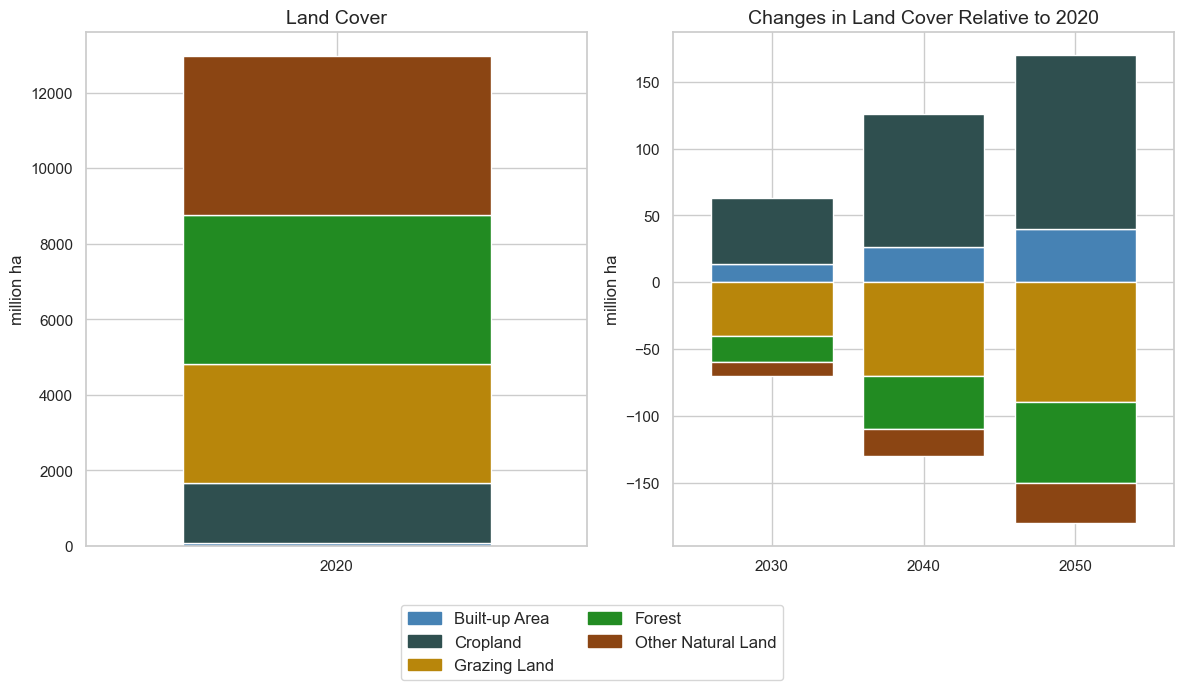

In [ ]:
## change to 2020 bar, stack changes
# pasture -> grazing land
# other -> Built-up Area


land_cover = pd.read_excel('../../../data/TOD/model_results/to_share/IMAGE_and_AIM_to_share_1.xlsx')
land_cover.rename(columns={'topic':'model'}, inplace=True)
land_cover = pyam.IamDataFrame(land_cover)
land_cover.filter(variable=[
    'bLand Cover|Cropland',
    'dLand Cover|Forest',
    'eLand Cover|Other Natural Land',
    'aLand Cover|Other',
    'cLand Cover|Pasture'
    ], year=[2020,2030,2040,2050],scenario='REF',region='World',inplace=True)

colors = {
    'aLand Cover|Other': 'steelblue',
    'bLand Cover|Cropland': 'darkslategray',
    'cLand Cover|Pasture': 'darkgoldenrod',
    'dLand Cover|Forest': 'forestgreen',
    'eLand Cover|Other Natural Land': 'saddlebrown',
    }

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

land_cover_2020 = land_cover.filter(year=2020)
var_list = [
    'aLand Cover|Other',
    'bLand Cover|Cropland',
    'cLand Cover|Pasture',
    'dLand Cover|Forest',
    'eLand Cover|Other Natural Land',
]
# Plot the stacked bar chart for land cover data (original values)
land_cover_2020.plot.bar(stacked=True, ax=axes[0], width=0.8)

# Assign colors to each segment of the stacked bars

patches = axes[0].patches
num_variables = len(var_list)
num_patches = len(patches)
patch_counter = 0  # To track patches for each variable

for i, var in enumerate(var_list):
    color = colors.get(var, 'firebrick')
    num_patches_per_var = num_patches // num_variables
    for j in range(num_patches_per_var):
        patches[patch_counter].set_facecolor(color)
        patch_counter += 1  # Move to the next patch

# Set title and other properties for the first subplot
axes[0].set_title("Land Cover", fontsize=14)
axes[0].set_xlabel(None)  # Remove x-axis label
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Prepare data for absolute changes (second plot)
land_cover_df = land_cover.as_pandas()
land_cover_pivot = land_cover_df.pivot_table(index='variable', columns='year', values='value')
land_cover_changes = land_cover_pivot.subtract(land_cover_pivot[2020], axis=0)
land_cover_changes.drop(columns=[2020], inplace=True)
land_cover_changes = land_cover_changes.T
print(land_cover_changes)
line_colors = [colors.get(var, 'firebrick') for var in var_list]
# Plot the changes in land cover (absolute changes)
land_cover_changes.plot.bar(ax=axes[1],stacked=True, width=0.8)

# Assign colors to each segment of the bars
patches = axes[1].patches
num_variables = len(var_list)
num_patches = len(patches)
patch_counter = 0  # To track patches for each variable

for i, var in enumerate(var_list):
    color = colors.get(var, 'firebrick')
    num_patches_per_var = num_patches // num_variables
    for j in range(num_patches_per_var):
        patches[patch_counter].set_facecolor(color)
        patch_counter += 1  # Move to the next patch

# Set title and other properties for the second subplot
axes[1].set_title("Changes in Land Cover Relative to 2020", fontsize=14)
axes[1].set_xlabel(None)  # Remove x-axis label
axes[1].set_ylabel("million ha", fontsize=12)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)  # Rotate x-tick labels to 0

# Remove legends from both subplots
axes[0].legend().set_visible(False)
axes[1].legend().set_visible(False)

legend_labels = [var.split('|')[1] for var in colors.keys()]  # Drop "Land Cover|"
# Rename labels
new_labels = {
    'Other': 'Built-up Area',
    'Cropland': 'Cropland',
    'Pasture': 'Grazing Land',
    'Forest': 'Forest',
    'Other Natural Land': 'Other Natural Land'
}
legend_labels = [new_labels.get(label, label) for label in legend_labels]
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(colors.values(), legend_labels)]

# Add the legend to the figure at the bottom with 2 columns
fig.legend(handles=legend_patches, loc='upper center', bbox_to_anchor=(0.5, -0.009), ncol=2, fontsize=12)

# Adjust layout to prevent overlap
plt.tight_layout()

variable_name = "landcover"
variable_name = "10.10_" + variable_name
plt.savefig(f"../../../plots/TOD/final_figures/chpt_10/{variable_name}.png", bbox_inches="tight")
plt.savefig(f"../../../plots/TOD/final_figures/chpt_10/{variable_name}.svg", bbox_inches="tight")

# Apply the rename mapping to variables
data = land_cover.timeseries()
data = data.reset_index()
data = data.drop(columns=['model','scenario','region'])
output_file = f"../../../plots/TOD/final_figures/chpt_10/data_for_figures/{variable_name}_data.xlsx"
data.to_excel(output_file, index=False)


## 10.11


variable   Cropland      Forest  Grazing Land  Other natural
year                                                        
2020      77.142886  211.781740     77.129561      69.447583
2030      -0.720395    0.980258      0.016936       0.403407
2040      -1.437541    1.546558     -0.125843       0.743703
2050      -2.166205    1.754254     -0.378134       1.060037


C:\Users\maycocks\AppData\Local\Temp\2\ipykernel_1368\1321282893.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)  # Set x-tick labels to be horizontal


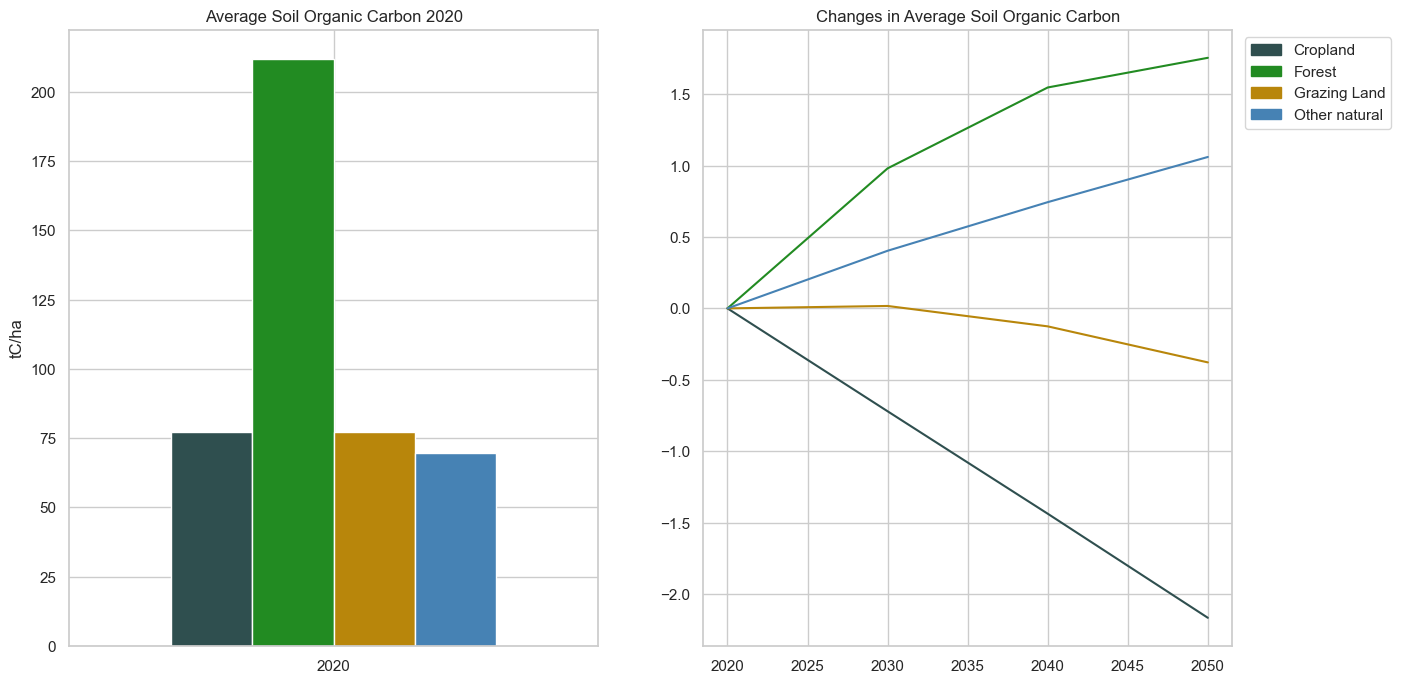

In [28]:
#grassland -> grazing land
# bar graph -> line graph 2nd plot
soc = pd.read_excel(r'X:\user\maycocks\GEO7\additional_figure_data\11.18_10.11_SOC_output_LUconst_figureGEO7.xlsx', sheet_name='Sheet1')
soc.rename(columns={'topic':'model'}, inplace=True)
soc = pyam.IamDataFrame(soc)
soc_2020 = soc.filter(year=[2020])
soc_changes = soc.filter(year=[2020, 2030, 2040, 2050])
custom_palette_bar = [
    "darkslategray",
    "forestgreen",
    "darkgoldenrod",
    "steelblue",
]

custom_palette = {
"Cropland": "darkslategray",
"Forest": "forestgreen",
"Grazing Land": "darkgoldenrod",
"Other natural": "steelblue",
}
var_list = [
    'Cropland',
    'Forest',
    'Grazing Land',
    'Other natural'
]


fig, axes = plt.subplots(figsize=(15, 8),ncols=2)
soc_2020.plot.bar(ax=axes[0], 
                  width=0.8,
                  )
axes[0].legend().set_visible(False)
bars = axes[0].patches

for i, bar in enumerate(bars):
    variable_name = soc_2020['variable'].iloc[i]  # Get the variable name for this bar
    color_idx = list(soc_2020['variable'].unique()).index(variable_name)  # Find the index for the variable
    bar.set_facecolor(custom_palette_bar[color_idx % len(custom_palette_bar)])

legend_labels = soc_2020['variable'].unique()  # Get unique variable names for legend

# Create custom patches for the legend with the corresponding colors
legend_patches = [mpatches.Patch(color=custom_palette_bar[i % len(custom_palette_bar)], label=legend_labels[i]) 
                for i in range(len(legend_labels))]

# Update legend: Place it outside the plot, aligned to the top right
axes[0].legend(handles=legend_patches,
            bbox_to_anchor=(2.21, 1),  # Position the legend outside
            loc='upper left')

axes[0].set_xlabel(None)  # Remove x-axis label
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)  # Set x-tick labels to be horizontal
axes[0].set_title('Average Soil Organic Carbon 2020')
line_colors = [custom_palette.get(var, 'firebrick') for var in var_list]
soc_changes_df = soc_changes.as_pandas()
soc_changes_df = soc_changes_df.pivot_table(index='year', columns='variable', values='value')
print(soc_changes_df)
soc_changes_df.loc[2020, :] = 0
soc_changes_df.plot.line(ax=axes[1], color=line_colors)
# bars = axes[1].patches
# for i, bar in enumerate(bars):
#     variable_name = soc_changes['variable'].iloc[i]  # Get the variable name for this bar
#     color_idx = list(soc_changes['variable'].unique()).index(variable_name)  # Find the index for the variable
#     bar.set_facecolor(custom_palette[color_idx % len(custom_palette)])

axes[1].legend().set_visible(False)
axes[1].set_xlabel(None)  # Remove x-axis label
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)  # Set x-tick labels to be horizontal
axes[1].set_title('Changes in Average Soil Organic Carbon')  # Set title for axes[1]

variable_name = "SOC"
variable_name = "10.11_" + variable_name
plt.savefig(f"../../../plots/TOD/final_figures/chpt_10/{variable_name}.png", bbox_inches="tight")
plt.savefig(f"../../../plots/TOD/final_figures/chpt_10/{variable_name}.svg", bbox_inches="tight")

# Apply the rename mapping to variables
data = soc.timeseries()
data = data.reset_index()
data = data.drop(columns=['model','scenario','region'])
output_file = f"../../../plots/TOD/final_figures/chpt_10/data_for_figures/{variable_name}_data.xlsx"
data.to_excel(output_file, index=False)


## 10.13
- Water quality Nitrogen pollution
- Water quality Phosphorus pollution

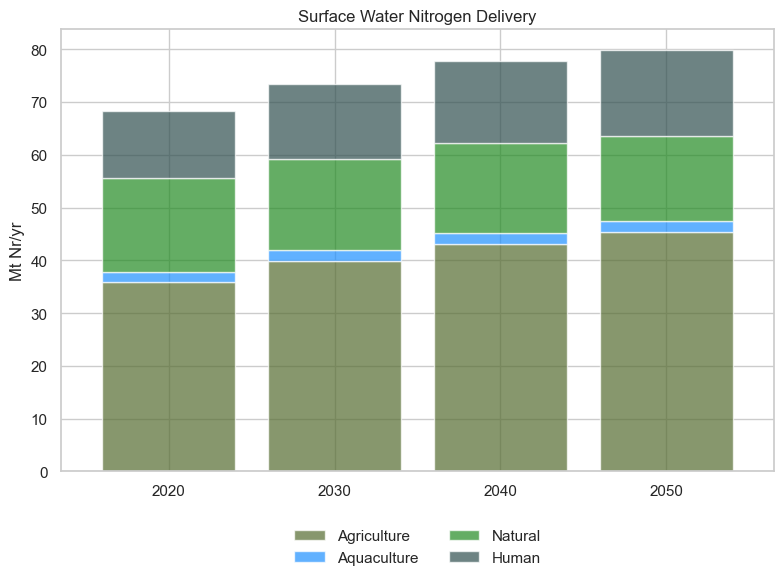

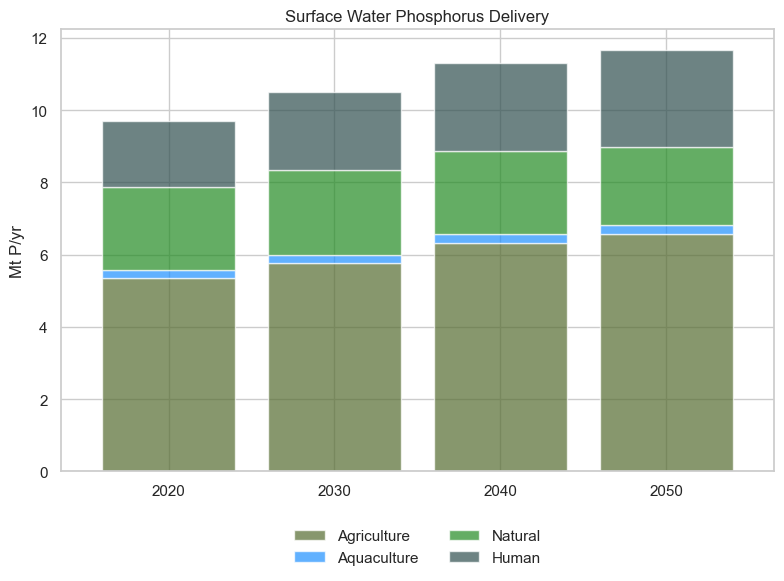

In [15]:
var_dict =  {
    'Surface Water Nitrogen Delivery':[[
        'Water Quality|Nitrogen|Delivery|Agriculture',
        'Water Quality|Nitrogen|Delivery|Aquaculture',
        'Water Quality|Nitrogen|Delivery|Natural',
        'Water Quality|Nitrogen|Delivery|Pointsources',
    ]],
    'Surface Water Phosphorus Delivery':[[
        'Water Quality|Phosphorus|Delivery|Agriculture',
        'Water Quality|Phosphorus|Delivery|Aquaculture',
        'Water Quality|Phosphorus|Delivery|Natural',
        'Water Quality|Phosphorus|Delivery|Pointsources',
    ]]
    }
rename_variables = {
    'Water Quality|Nitrogen|Delivery|Agriculture': 'Agriculture',
    'Water Quality|Nitrogen|Delivery|Aquaculture': 'Aquaculture',
    'Water Quality|Nitrogen|Delivery|Natural': 'Natural',
    'Water Quality|Nitrogen|Delivery|Pointsources': 'Human',
    'Water Quality|Phosphorus|Delivery|Agriculture': 'Agriculture',
    'Water Quality|Phosphorus|Delivery|Aquaculture': 'Aquaculture',
    'Water Quality|Phosphorus|Delivery|Natural': 'Natural',
    'Water Quality|Phosphorus|Delivery|Pointsources': 'Human',
}

for share in var_dict.keys():
    var_list = var_dict[share][0]

    data = df_geo.filter(variable=var_list,
            year=[2010, 2020, 2030, 2040, 2050])
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot stacked bars instead of stacked lines
    data.plot.bar(stacked=True, ax=ax, alpha=0.7, width=0.8)

    # ASSIGN COLORS
    # Now loop through the segments of each bar (patches)
    patches = ax.patches
    num_variables = len(var_list)
    num_patches = len(patches)
    patch_counter = 0  # To track patches for each variable
    for i, var in enumerate(var_list):
        color = color_dict.get(var, 'firebrick')  
        num_patches_per_var = num_patches // num_variables  
        # Loop over the patches and assign colors to the correct ones
        for j in range(num_patches_per_var):
            patches[patch_counter].set_facecolor(color)
            patch_counter += 1  # Move to the next patch
            
    title = share.replace("Shares", "")
    ax.set_title(title)
    
    ax.set(xlabel=None)
    ax.legend().set_visible(True)
    # Get the current legend handles and labels
    handles, labels = ax.get_legend_handles_labels()

    # Replace labels with the dictionary values if found
    new_labels = [rename_variables.get(label, label) for label in labels]
    
    ax.legend(handles, new_labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncols=2, frameon=False)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)  # Ensure proper x-axis labeling
    # ax.set_ylabel(unit)
    plt.tight_layout()

    variable_name = share.replace("(", "_").replace(")","").replace(" ", "_")
    variable_name = "10.13_" + variable_name
    plt.savefig(f"../../../plots/TOD/final_figures/chpt_10/{variable_name}.png", bbox_inches="tight")
    plt.savefig(f"../../../plots/TOD/final_figures/chpt_10/{variable_name}.svg", bbox_inches="tight")

    # Apply the rename mapping to variables
    data = data.rename(variable=rename_variables)
    data = data.timeseries()
    data = data.reset_index()
    data = data.drop(columns=['model','scenario','region'])
    output_file = f"../../../plots/TOD/final_figures/chpt_10/data_for_figures/{variable_name}_data.xlsx"
    data.to_excel(output_file, index=False)

## 10.14

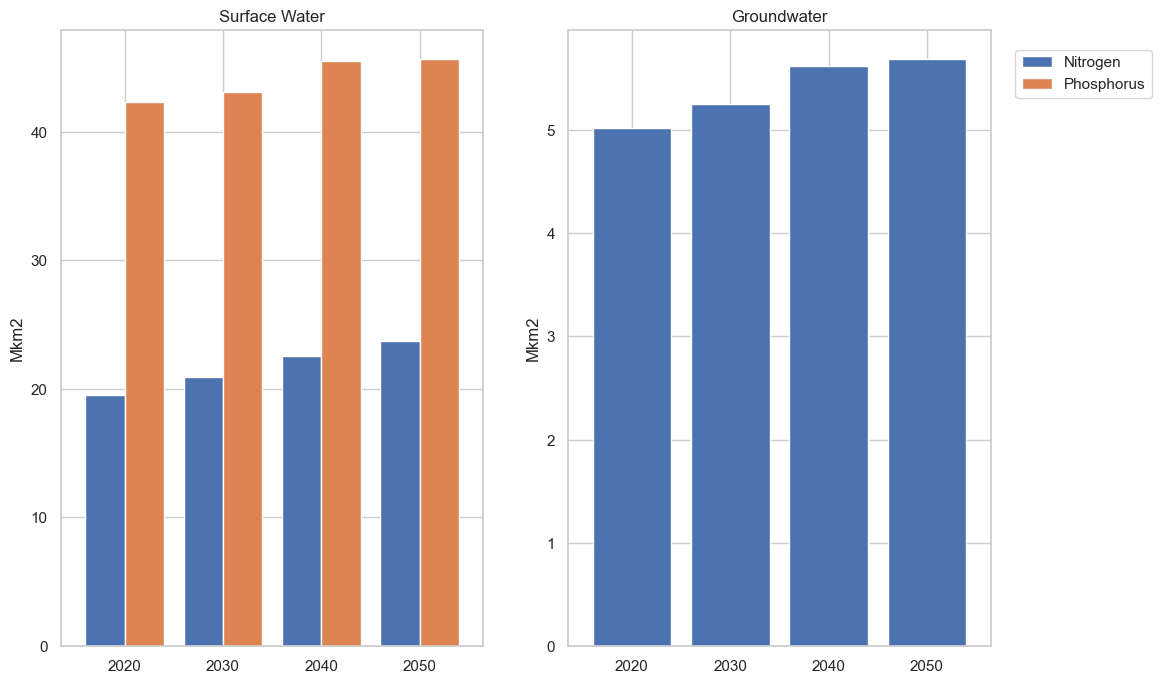

In [ ]:
threshold = pd.read_excel(r'X:\user\maycocks\GEO7\additional_figure_data\11.22_thresholds_figures.xlsx', sheet_name='Sheet2')
threshold.rename(columns={'topic':'model'}, inplace=True)
threshold = pyam.IamDataFrame(threshold)
threshold_sw = threshold.filter(year=[2020, 2030, 2040, 2050],variable=['Nitrogen','Phosphorus'])
gw_threshold = threshold.filter(year=[2020, 2030, 2040, 2050],variable=['Nitrogen GW'])

fig, axes = plt.subplots(figsize=(12, 8),ncols=2)

threshold_sw.plot.bar(ax=axes[0], width=0.8)
axes[0].set_title('Surface Water')
axes[0].set(xlabel=None)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)


gw_threshold.plot.bar(ax=axes[1], width=0.8)
axes[1].set_title('Groundwater')
axes[1].set(xlabel=None)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
axes[1].legend().set_visible(False)
axes[0].legend(bbox_to_anchor=(2.6, 0.98))

variable_name = "N_P_thresholds"
variable_name = "10.14_" + variable_name
plt.savefig(f"../../../plots/TOD/final_figures/chpt_10/{variable_name}.png", bbox_inches="tight")
plt.savefig(f"../../../plots/TOD/final_figures/chpt_10/{variable_name}.svg", bbox_inches="tight")

# Apply the rename mapping to variables
data = threshold.timeseries()
data = data.reset_index()
data = data.drop(columns=['model','scenario','region'])
output_file = f"../../../plots/TOD/final_figures/chpt_10/data_for_figures/{variable_name}_data.xlsx"
data.to_excel(output_file, index=False)


## 10.15
- Global water withdrawal per sector
- risk of water stress (no data?)

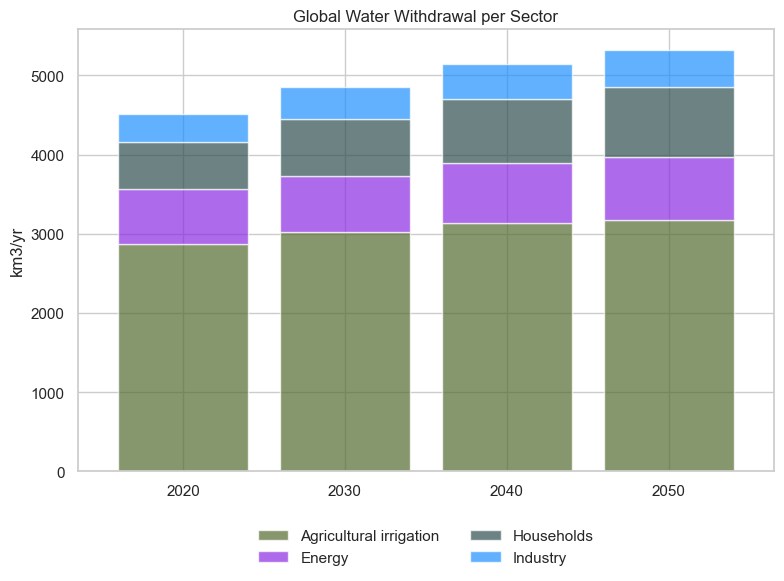

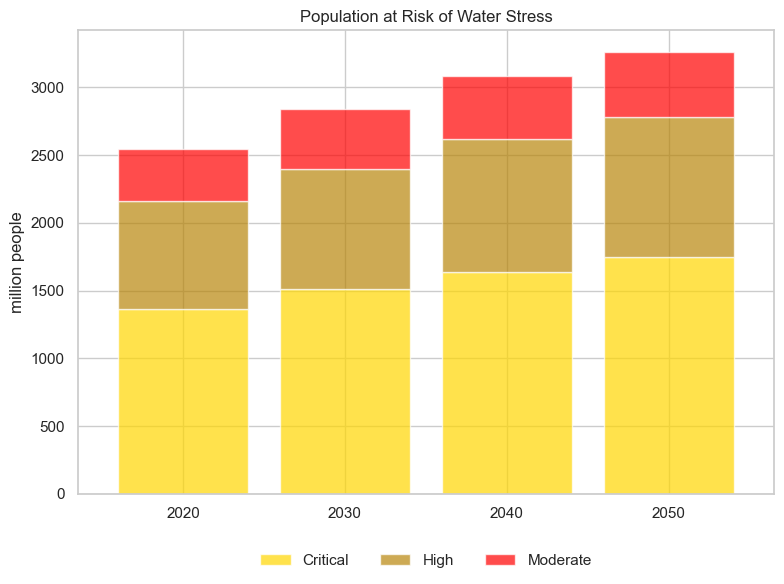

In [10]:

var_dict =  {
    'Global Water Withdrawal per Sector':[[
        'Agricultural irrigation',
        'Energy',
        'Industry',
        'Households'
    ]],
    'Population at Risk of Water Stress':[[
        'Moderate',
        'High',
        'Critical',
    ]]
    }

df_water_geo = pd.read_excel(r'X:\user\maycocks\GEO7\additional_figure_data\10.15_water_withdrawal_figure.xlsx')
df_population_stress = pd.read_excel(r'X:\user\maycocks\GEO7\additional_figure_data\10.15_waterstress_regoutput_figures_sept24.xlsx')
df_water_geo = pyam.IamDataFrame(df_water_geo)
df_population_stress = pyam.IamDataFrame(df_population_stress)
df_water_geo = pyam.concat([df_water_geo, df_population_stress])
for share in var_dict.keys():
    var_list = var_dict[share][0]

    data = df_water_geo.filter(variable=var_list,
            year=[2010, 2020, 2030, 2040, 2050])
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot stacked bars instead of stacked lines
    data.plot.bar(stacked=True, ax=ax, alpha=0.7, width=0.8)

    # ASSIGN COLORS
    # Now loop through the segments of each bar (patches)
    patches = ax.patches
    num_variables = len(var_list)
    num_patches = len(patches)
    patch_counter = 0  # To track patches for each variable
    for i, var in enumerate(var_list):
        color = color_dict.get(var, 'firebrick')  
        num_patches_per_var = num_patches // num_variables  
        # Loop over the patches and assign colors to the correct ones
        for j in range(num_patches_per_var):
            patches[patch_counter].set_facecolor(color)
            patch_counter += 1  # Move to the next patch
            
    title = share.replace("Shares", "")
    ax.set_title(title)
    
    ax.set(xlabel=None)
    ax.legend().set_visible(True)
    # Get the current legend handles and labels
    handles, labels = ax.get_legend_handles_labels()
    if share == 'Global Water Withdrawal per Sector':
        ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncols=2, frameon=False)
    else:
        ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncols=3, frameon=False)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)  # Ensure proper x-axis labeling
    # ax.set_ylabel(unit)
    plt.tight_layout()

    variable_name = share.replace("(", "_").replace(")","").replace(" ", "_")
    variable_name = "10.15_" + variable_name
    plt.savefig(f"../../../plots/TOD/final_figures/chpt_10/{variable_name}.png", bbox_inches="tight")
    plt.savefig(f"../../../plots/TOD/final_figures/chpt_10/{variable_name}.svg", bbox_inches="tight")

    # Apply the rename mapping to variables
    data = data.timeseries()
    data = data.reset_index()
    data = data.drop(columns=['model','scenario','region'])
    output_file = f"../../../plots/TOD/final_figures/chpt_10/data_for_figures/{variable_name}_data.xlsx"
    data.to_excel(output_file, index=False)

## 10.17

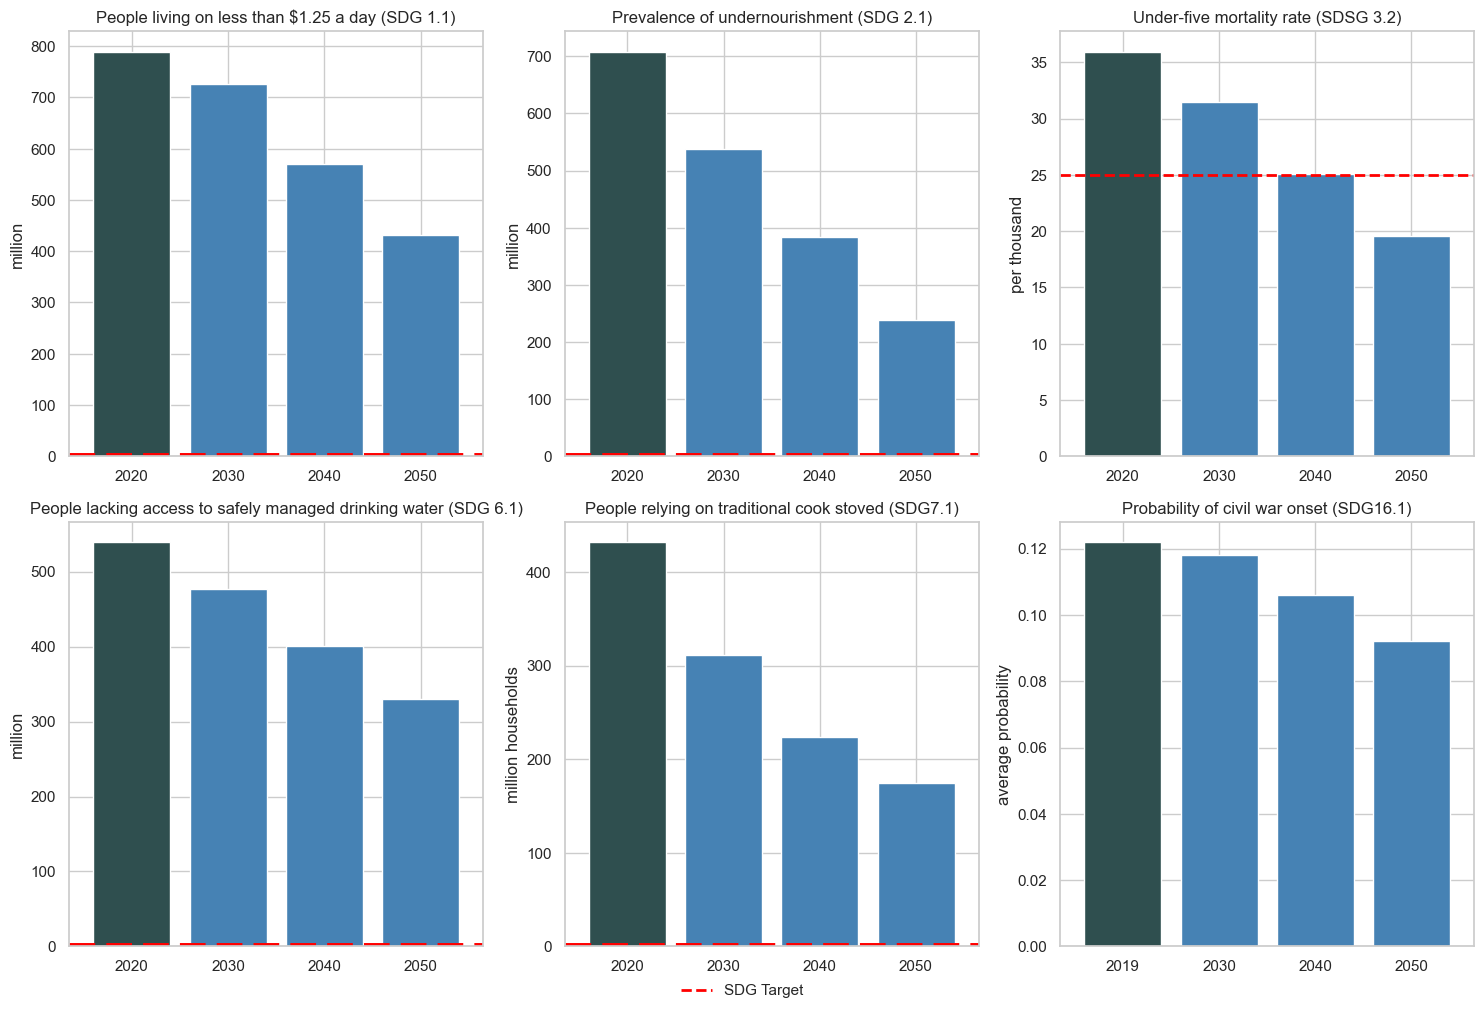

In [14]:
socio_econ = pd.read_excel(r'X:\user\maycocks\GEO7\additional_figure_data\11.25_27_GEO SOD IFs Graphs.xlsx', sheet_name='Sheet2')
socio_econ.rename(columns={'topic':'model'}, inplace=True)

socio_econ = pyam.IamDataFrame(socio_econ)
variable_list = [
    'Poverty < $2.15',
    'Undernourished People',
    'Under-five mortality rate',
    'Unimproved Water Access',
    'Traditional Cookstoves',
    'Civil War Onset'
]
title_dictionary = {
    'Poverty < $2.15': 'People living on less than $1.25 a day (SDG 1.1)',
    'Undernourished People': 'Prevalence of undernourishment (SDG 2.1)',
    'Under-five mortality rate': 'Under-five mortality rate (SDSG 3.2)',
    'Unimproved Water Access': 'People lacking access to safely managed drinking water (SDG 6.1)',
    'Traditional Cookstoves': 'People relying on traditional cook stoved (SDG7.1)',
    'Civil War Onset': 'Probability of civil war onset (SDG16.1)'
}
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()



for i, variable in enumerate(variable_list):
    data = socio_econ.filter(variable=variable, year=[2020,2030,2040,2050])
    bars = data.plot.bar(ax=axes[i], width=0.8)
    axes[i].set_title(title_dictionary[variable])
    axes[i].set(xlabel=None)
    for j, bar in enumerate(bars.patches):
        if j == 0:  # First bar (x-position 0)
            bar.set_facecolor('darkslategray')
        else:  # All other bars
            bar.set_facecolor('steelblue')
    if variable == 'Civil War Onset':
        current_labels = axes[i].get_xticklabels()
        updated_labels = ['2019' if label.get_text() == '2020' else label.get_text() for label in current_labels]
        # Apply updated labels to the plot
        axes[i].set_xticklabels(updated_labels, rotation=0)
    else:
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=0)
    axes[i].legend().set_visible(False)

# Add red horizontal line at y=0
for i in range(len(axes)):
    if i == 2:  # Only for the last subplot
        axes[i].axhline(y=25, color='red', linestyle='--', linewidth=2)
    elif i == 5:
        continue
    else:
        axes[i].axhline(y=0, color='red', linestyle='--', linewidth=5)

red_line = Line2D([0], [0], color='red', linestyle='--', linewidth=2, label='SDG Target')
fig.legend(handles=[red_line], loc='lower center', ncol=1, frameon=False, bbox_to_anchor=(0.5, -0.02))
plt.tight_layout()

variable_name = "10.17_socioeconomic_vars"
plt.savefig(f"../../../plots/TOD/final_figures/chpt_10/{variable_name}.png", bbox_inches="tight")
plt.savefig(f"../../../plots/TOD/final_figures/chpt_10/{variable_name}.svg", bbox_inches="tight")

# Apply the rename mapping to variables
data = socio_econ.timeseries()
data = data.reset_index()
data = data.drop(columns=['model','scenario','region'])
output_file = f"../../../plots/TOD/final_figures/chpt_10/data_for_figures/{variable_name}_data.xlsx"
data.to_excel(output_file, index=False)

    

## 10.19


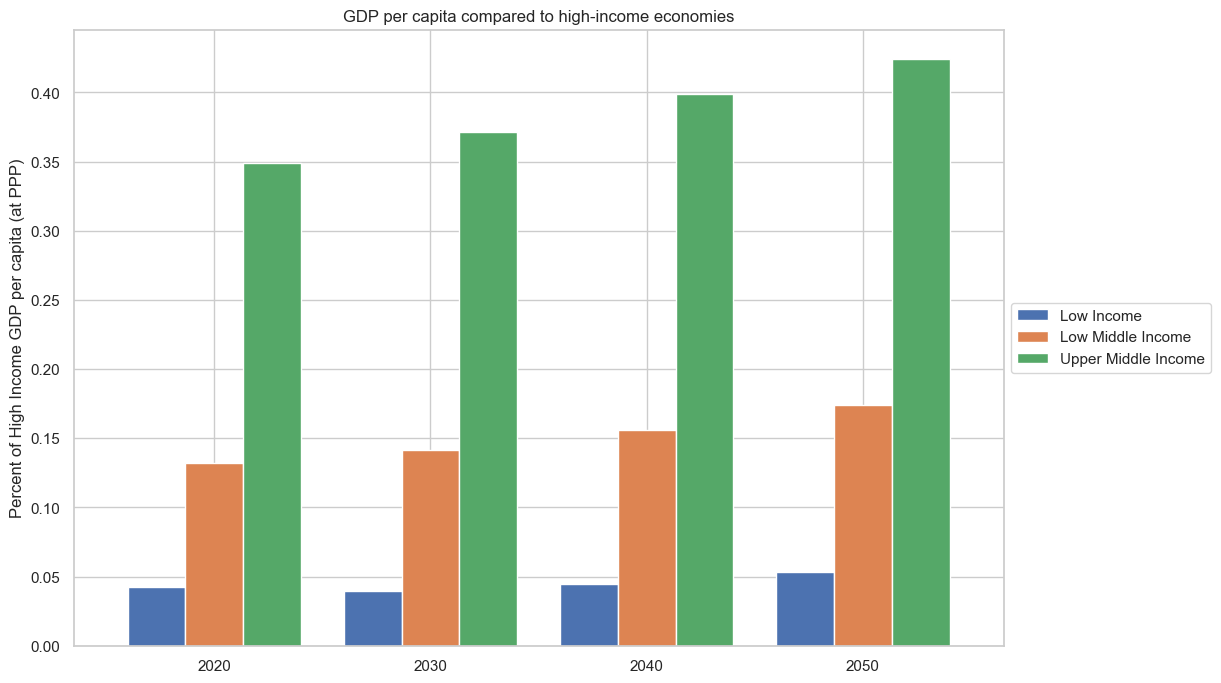

In [47]:

gdp_income = pd.read_excel(r'X:\user\maycocks\GEO7\additional_figure_data\11.25_27_GEO SOD IFs Graphs.xlsx', sheet_name='Sheet1')
gdp_income.rename(columns={'topic':'model'}, inplace=True)
gdp_income = pyam.IamDataFrame(gdp_income)

fig, ax = plt.subplots(figsize=(12, 8))

gdp_income.plot.bar(ax=ax, width=0.8)
ax.set_title('GDP per capita compared to high-income economies')
ax.set(xlabel=None)
ax.set(ylabel="Percent of High Income GDP per capita (at PPP)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

variable_name = "10.19_gdp_compared_high_income"
plt.savefig(f"../../../plots/TOD/final_figures/chpt_10/{variable_name}.png", bbox_inches="tight")
plt.savefig(f"../../../plots/TOD/final_figures/chpt_10/{variable_name}.svg", bbox_inches="tight")

# Apply the rename mapping to variables
data = gdp_income.timeseries()
data = data.reset_index()
data = data.drop(columns=['model','scenario','region'])
output_file = f"../../../plots/TOD/final_figures/chpt_10/data_for_figures/{variable_name}_data.xlsx"
data.to_excel(output_file, index=False)